In [1]:
# Install necessary packages and dependencies
# Method 1: Using conda to install libomp
!conda install -c conda-forge libomp -y
!pip install xgboost shap 
!pip install pycaret

import pycaret
print(pycaret.__version__)

# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning Imports
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Pipeline and Preprocessing Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from scipy.stats import randint
from imblearn.ensemble import BalancedRandomForestClassifier

# PyCaret Imports
from pycaret.classification import setup, compare_models, tune_model, evaluate_model, finalize_model, predict_model

Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/wallyk./anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
/ DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-arm64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG

3.3.2


# 1. Load & Explore Data

In [2]:
# Data Inspection and Understanding
# Load Data
# Path to the folder containing CSV files
folder_path = '/Users/wallyk./Desktop/CB-DS-17/Kaddle Basketball & Final Project/csv'

In [3]:
# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
# Debug: Print the list of CSV files to verify
print("CSV Files found:", csv_files)

CSV Files found: ['play_by_play.csv', 'game_info.csv', 'player.csv', 'team_history.csv', 'team_info_common.csv', 'inactive_players.csv', 'other_stats.csv', 'officials.csv', 'game_summary.csv', 'draft_combine_stats.csv', 'team_details.csv', 'draft_history.csv', 'line_score.csv', 'common_player_info.csv', 'team.csv', 'game.csv']


In [4]:
# Looking to see if we have the most complete dataset all in one
data = pd.read_csv("/Users/wallyk./Desktop/CB-DS-17/Kaddle Basketball & Final Project/csv/game.csv")

In [5]:
# Display basic information about the dataset
print("Data Info:")
print(data.info())  # Get information on column data types and number of non-null values
print("\nFirst 5 Rows:")
data 

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65698 entries, 0 to 65697
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season_id               65698 non-null  int64  
 1   team_id_home            65698 non-null  int64  
 2   team_abbreviation_home  65698 non-null  object 
 3   team_name_home          65698 non-null  object 
 4   game_id                 65698 non-null  int64  
 5   game_date               65698 non-null  object 
 6   matchup_home            65698 non-null  object 
 7   wl_home                 65696 non-null  object 
 8   min                     65698 non-null  int64  
 9   fgm_home                65685 non-null  float64
 10  fga_home                50251 non-null  float64
 11  fg_pct_home             50208 non-null  float64
 12  fg3m_home               52480 non-null  float64
 13  fg3a_home               47015 non-null  float64
 14  fg3_pct_home            466

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,...,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65693,42022,1610612748,MIA,Miami Heat,42200403,2023-06-07 00:00:00,MIA vs. DEN,L,240,34.0,...,58.0,28.0,3.0,5.0,14.0,18.0,109.0,15,1,Playoffs
65694,42022,1610612748,MIA,Miami Heat,42200404,2023-06-09 00:00:00,MIA vs. DEN,L,240,35.0,...,34.0,26.0,11.0,7.0,8.0,18.0,108.0,13,1,Playoffs
65695,42022,1610612743,DEN,Denver Nuggets,42200405,2023-06-12 00:00:00,DEN vs. MIA,W,240,38.0,...,44.0,18.0,9.0,7.0,8.0,21.0,89.0,-5,1,Playoffs
65696,32022,1610616834,LBN,Team LeBron,32200001,2023-02-19 00:00:00,LBN vs. GNS,L,221,79.0,...,46.0,43.0,8.0,1.0,12.0,2.0,184.0,9,1,All-Star


# 2. Data Cleaning

In [6]:
# Define a threshold for dropping columns with too many missing values, e.g., 50%
threshold = 0.5

# Drop columns with missing data exceeding the threshold
recent_data = data.loc[:, data.isnull().mean() < threshold]
# Drop rows with any missing data (you could also choose a threshold approach here)
recent_data = recent_data.dropna()

# Replace any remaining NaNs with the mean of each column (for numeric columns only)
# This step is optional and based on the scenario where some NaNs might still exist
numeric_cols = recent_data.select_dtypes(include=[np.number])  # selecting numeric columns
means = numeric_cols.mean()  # calculating means of numeric columns
recent_data.fillna(means, inplace=True)

In [7]:
recent_data["wl_home"]

14166    L
14167    L
14170    L
14171    W
14172    W
        ..
65691    W
65692    L
65693    L
65694    L
65695    W
Name: wl_home, Length: 46154, dtype: object

In [8]:
# Checking for missing values in the recent_data
print("\nMissing Values in Recent Data:")
print(recent_data.isnull().sum())

# Descriptive Statistics for recent_data
print("\nDescriptive Statistics for Recent Data:")
recent_data.describe()  # Summary statistics for numerical columns


Missing Values in Recent Data:
season_id                 0
team_id_home              0
team_abbreviation_home    0
team_name_home            0
game_id                   0
game_date                 0
matchup_home              0
wl_home                   0
min                       0
fgm_home                  0
fga_home                  0
fg_pct_home               0
fg3m_home                 0
fg3a_home                 0
fg3_pct_home              0
ftm_home                  0
fta_home                  0
ft_pct_home               0
oreb_home                 0
dreb_home                 0
reb_home                  0
ast_home                  0
stl_home                  0
blk_home                  0
tov_home                  0
pf_home                   0
pts_home                  0
plus_minus_home           0
video_available_home      0
team_id_away              0
team_abbreviation_away    0
team_name_away            0
matchup_away              0
wl_away                   0
fgm_away        

,season_id,team_id_home,game_id,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away
count,46154.000000,4.615400e+04,4.615400e+04,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,...,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000,46154.000000
mean,22850.369350,1.609636e+09,2.485092e+07,241.720761,38.873814,83.613490,0.465641,6.439009,18.030420,0.347230,...,30.265221,41.919249,21.955302,7.838974,4.672574,15.145145,22.257399,100.484487,-3.321164,0.286541
std,5099.971707,3.965843e+07,6.572632e+06,7.381676,5.928227,8.553499,0.058408,4.376682,10.412325,0.148882,...,5.582644,6.632564,5.301339,3.024206,2.493421,4.271156,4.876096,13.416635,13.384269,0.452150
min,12005.000000,4.500000e+01,1.050000e+07,180.000000,17.000000,53.000000,0.234000,0.000000,1.000000,0.000000,...,4.000000,18.000000,4.000000,0.000000,0.000000,0.000000,2.000000,53.000000,-73.000000,0.000000
25%,21994.000000,1.610613e+09,2.080033e+07,240.000000,35.000000,78.000000,0.425000,3.000000,10.000000,0.263000,...,26.000000,37.000000,18.000000,6.000000,3.000000,12.000000,19.000000,91.000000,-12.000000,0.000000
50%,22005.000000,1.610613e+09,2.180104e+07,240.000000,39.000000,83.000000,0.464000,6.000000,16.000000,0.350000,...,30.000000,42.000000,22.000000,8.000000,4.000000,15.000000,22.000000,100.000000,-4.000000,0.000000
75%,22015.000000,1.610613e+09,2.920001e+07,240.000000,43.000000,89.000000,0.506000,9.000000,24.000000,0.432000,...,34.000000,46.000000,25.000000,10.000000,6.000000,18.000000,25.000000,109.000000,6.000000,1.000000
max,42022.000000,1.610617e+09,4.980009e+07,365.000000,84.000000,143.000000,0.697000,28.000000,77.000000,1.000000,...,60.000000,81.000000,52.000000,24.000000,19.000000,40.000000,52.000000,196.000000,68.000000,1.000000


In [9]:
# Convert 'W' to 1 and 'L' to 0 in the 'wl_home' column
recent_data['wl_home'] = recent_data['wl_home'].map({'W': 1, 'L': 0})

In [10]:
# Use select_dtypes to filter only numeric columns for calculating the mean
numeric_cols = recent_data.select_dtypes(include=[np.number])

In [11]:
# Calculate the mean only for numeric columns
means = numeric_cols.mean()
means

season_id               2.285037e+04
team_id_home            1.609636e+09
game_id                 2.485092e+07
wl_home                 6.033713e-01
min                     2.417208e+02
fgm_home                3.887381e+01
fga_home                8.361349e+01
fg_pct_home             4.656407e-01
fg3m_home               6.439009e+00
fg3a_home               1.803042e+01
fg3_pct_home            3.472295e-01
ftm_home                1.961938e+01
fta_home                2.591223e+01
ft_pct_home             7.577530e-01
oreb_home               1.207887e+01
dreb_home               3.142352e+01
reb_home                4.350269e+01
ast_home                2.369101e+01
stl_home                7.976253e+00
blk_home                5.290961e+00
tov_home                1.473088e+01
pf_home                 2.148091e+01
pts_home                1.038057e+02
plus_minus_home         3.321164e+00
video_available_home    2.865407e-01
team_id_away            1.608275e+09
fgm_away                3.776106e+01
f

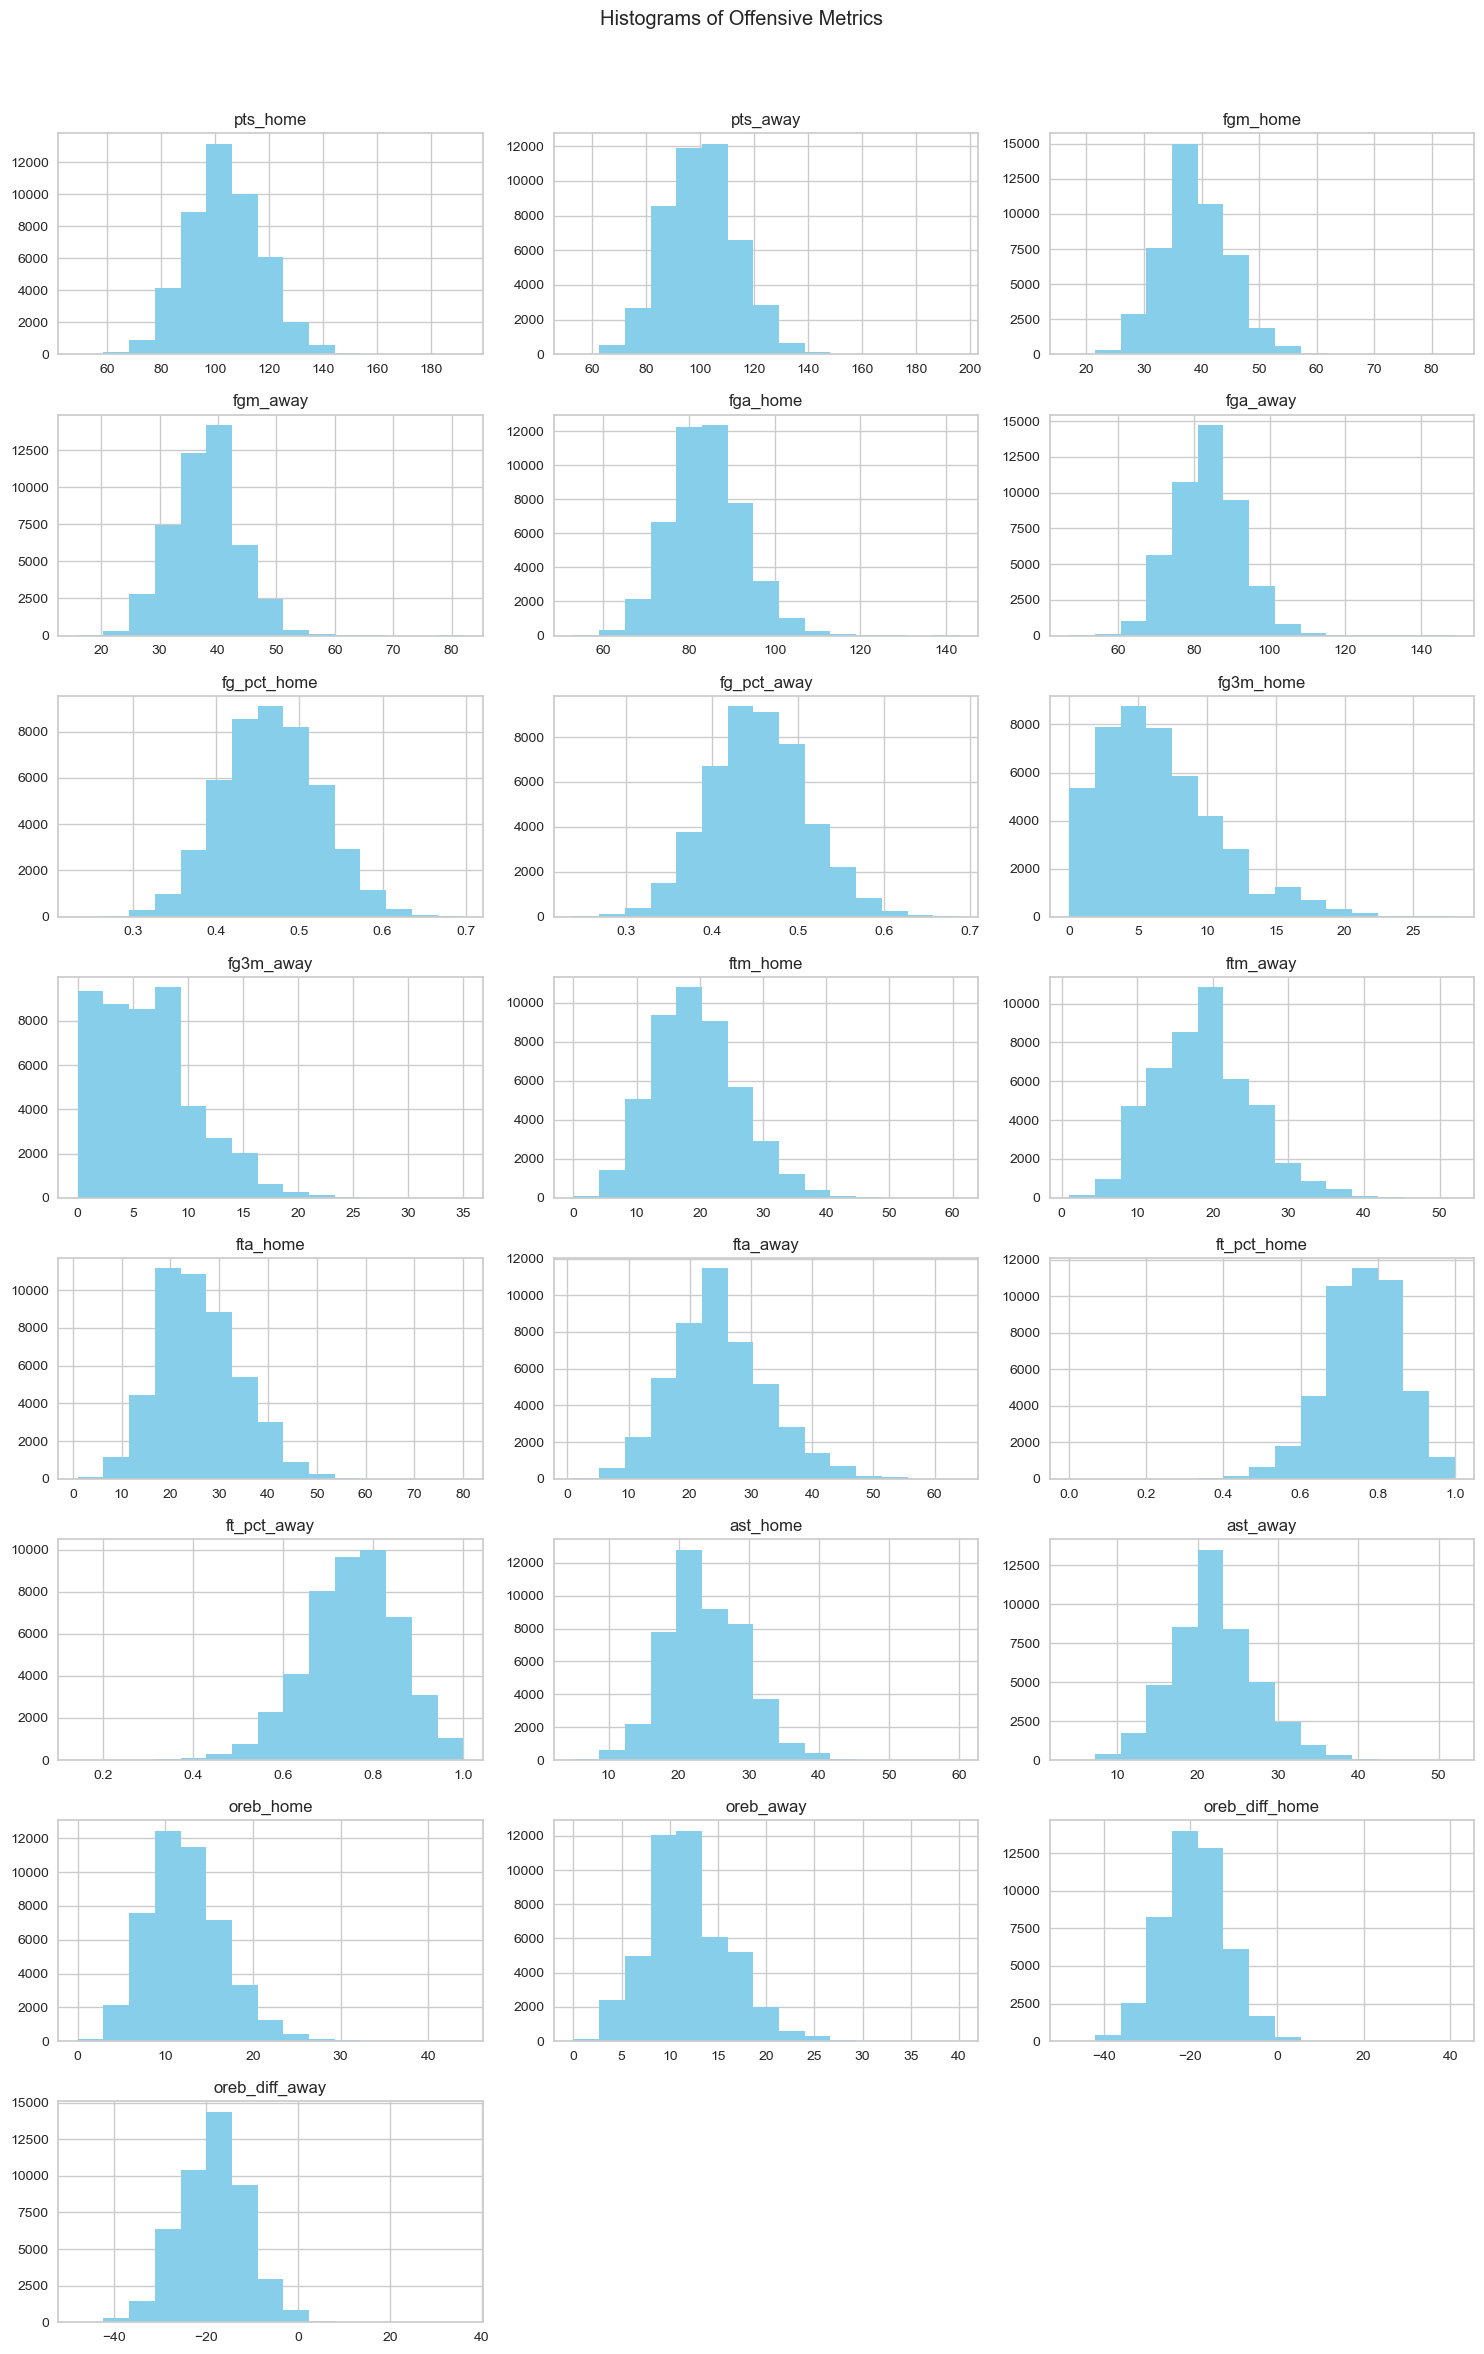

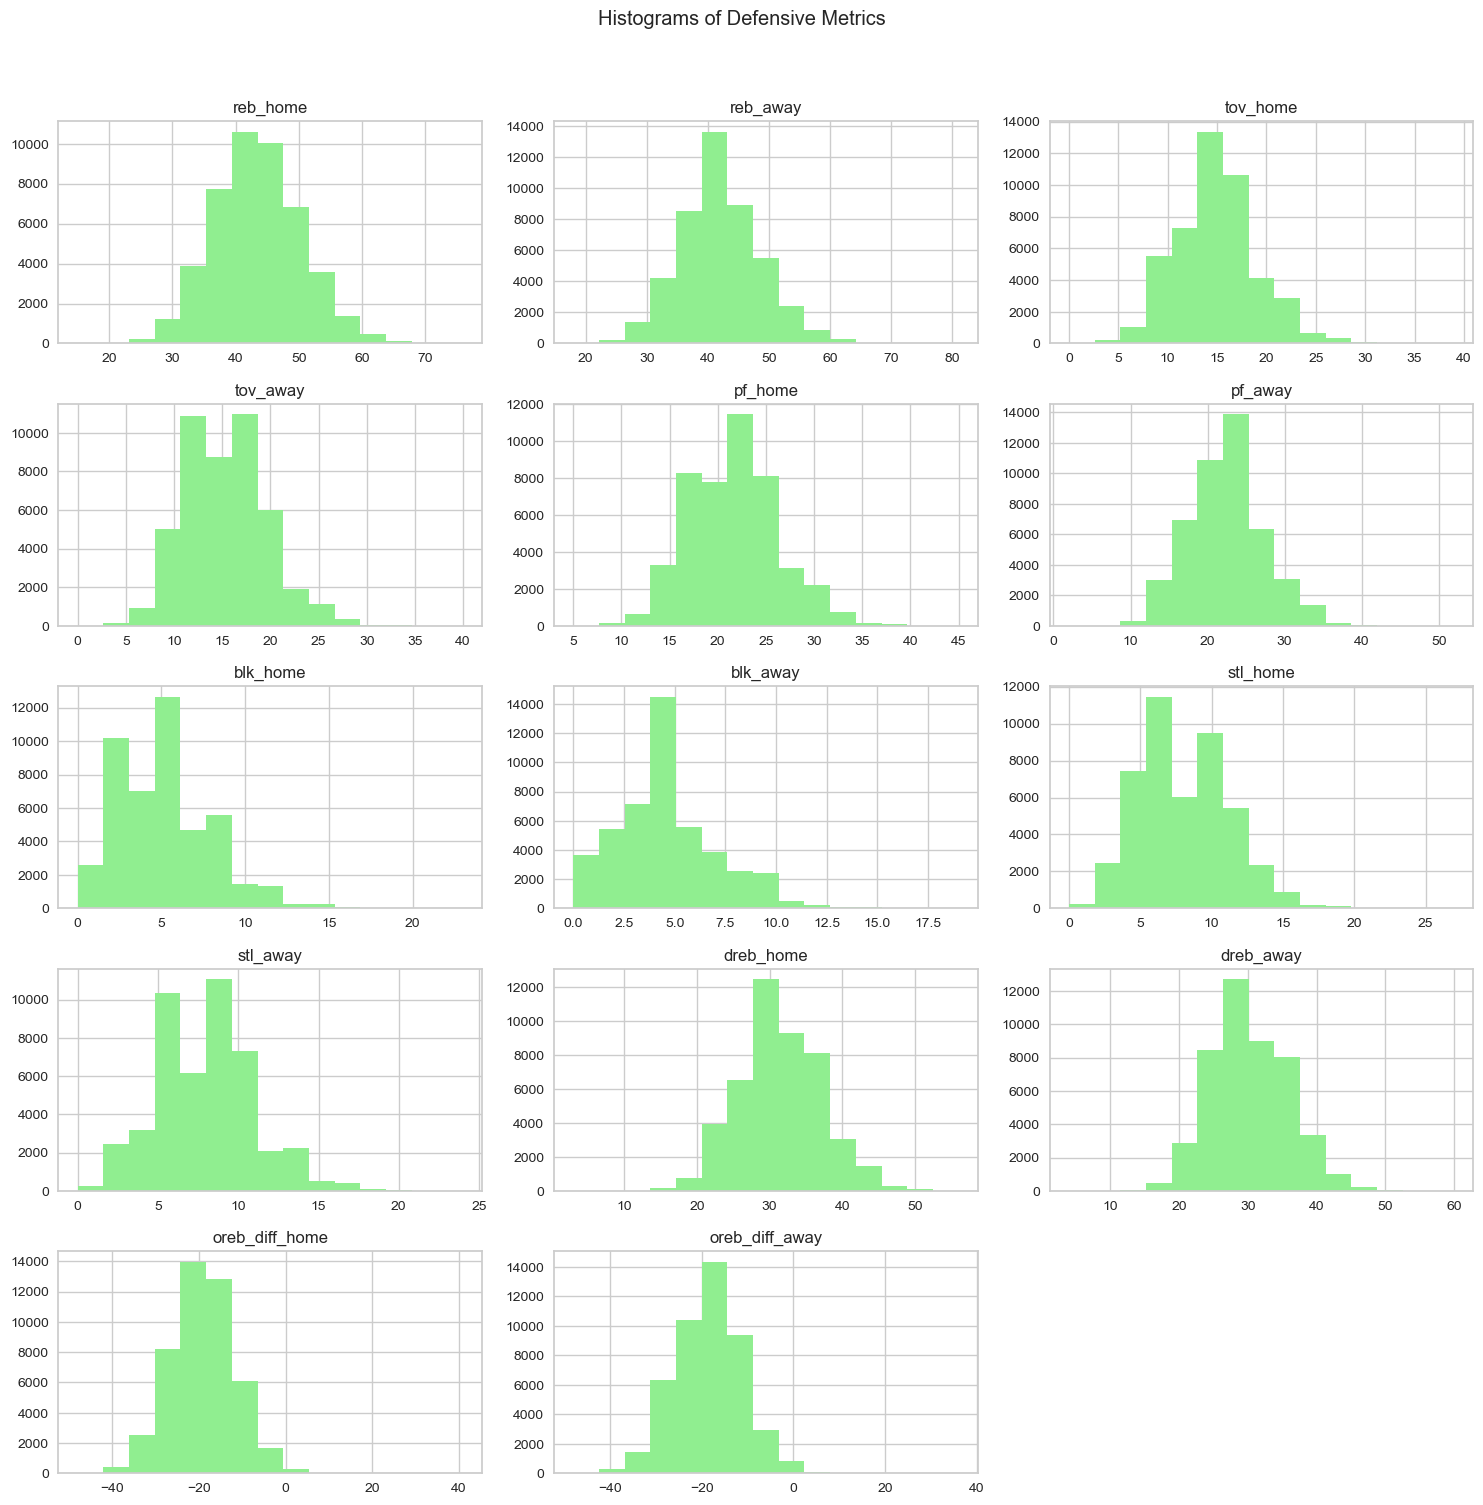

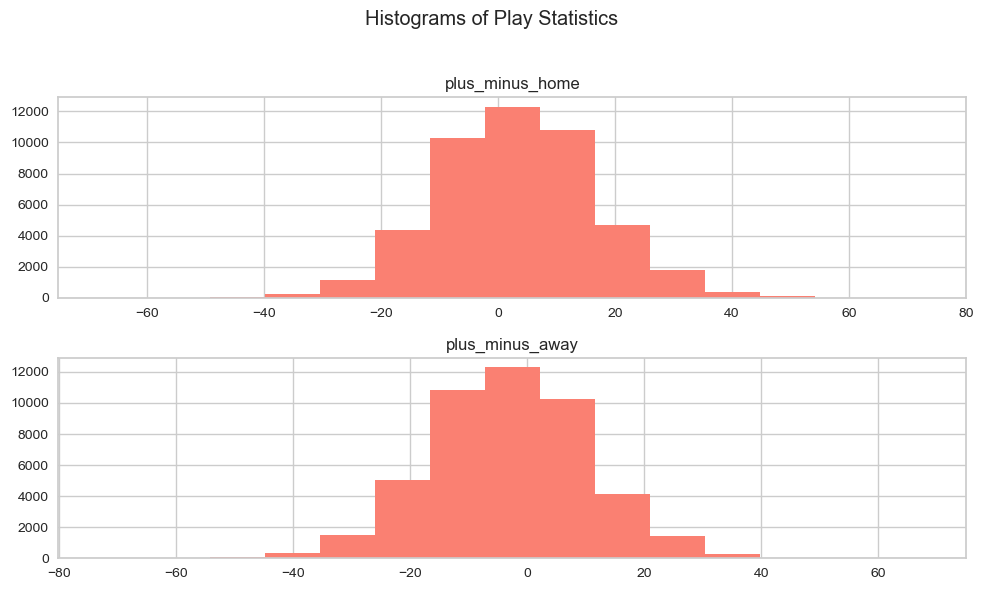

In [12]:
# Visualizations
# Select key columns for histograms
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Calculate the difference between offensive and defensive rebounds
recent_data['oreb_diff_home'] = recent_data['oreb_home'] - recent_data['dreb_home']
recent_data['oreb_diff_away'] = recent_data['oreb_away'] - recent_data['dreb_away']

# Add these new columns to the respective metrics lists
offensive_metrics.extend(['oreb_diff_home', 'oreb_diff_away'])
defensive_metrics.extend(['oreb_diff_home', 'oreb_diff_away'])

# Adjust layout dimensions to accommodate all metrics
offensive_layout = (8, 3)  # 24 plots (7 original rows + 1 row for 2 new metrics)
defensive_layout = (6, 3)  # 18 plots (5 original rows + 1 row for 2 new metrics)
play_stats_layout = (2, 1)  # 2 plots

# Visualize offensive metrics
recent_data[offensive_metrics].hist(bins=15, figsize=(15, 24), layout=offensive_layout, color='skyblue')
plt.suptitle('Histograms of Offensive Metrics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize defensive metrics
recent_data[defensive_metrics].hist(bins=15, figsize=(15, 18), layout=defensive_layout, color='lightgreen')
plt.suptitle('Histograms of Defensive Metrics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize additional play statistics
recent_data[play_stats].hist(bins=15, figsize=(10, 6), layout=play_stats_layout, color='salmon')
plt.suptitle('Histograms of Play Statistics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


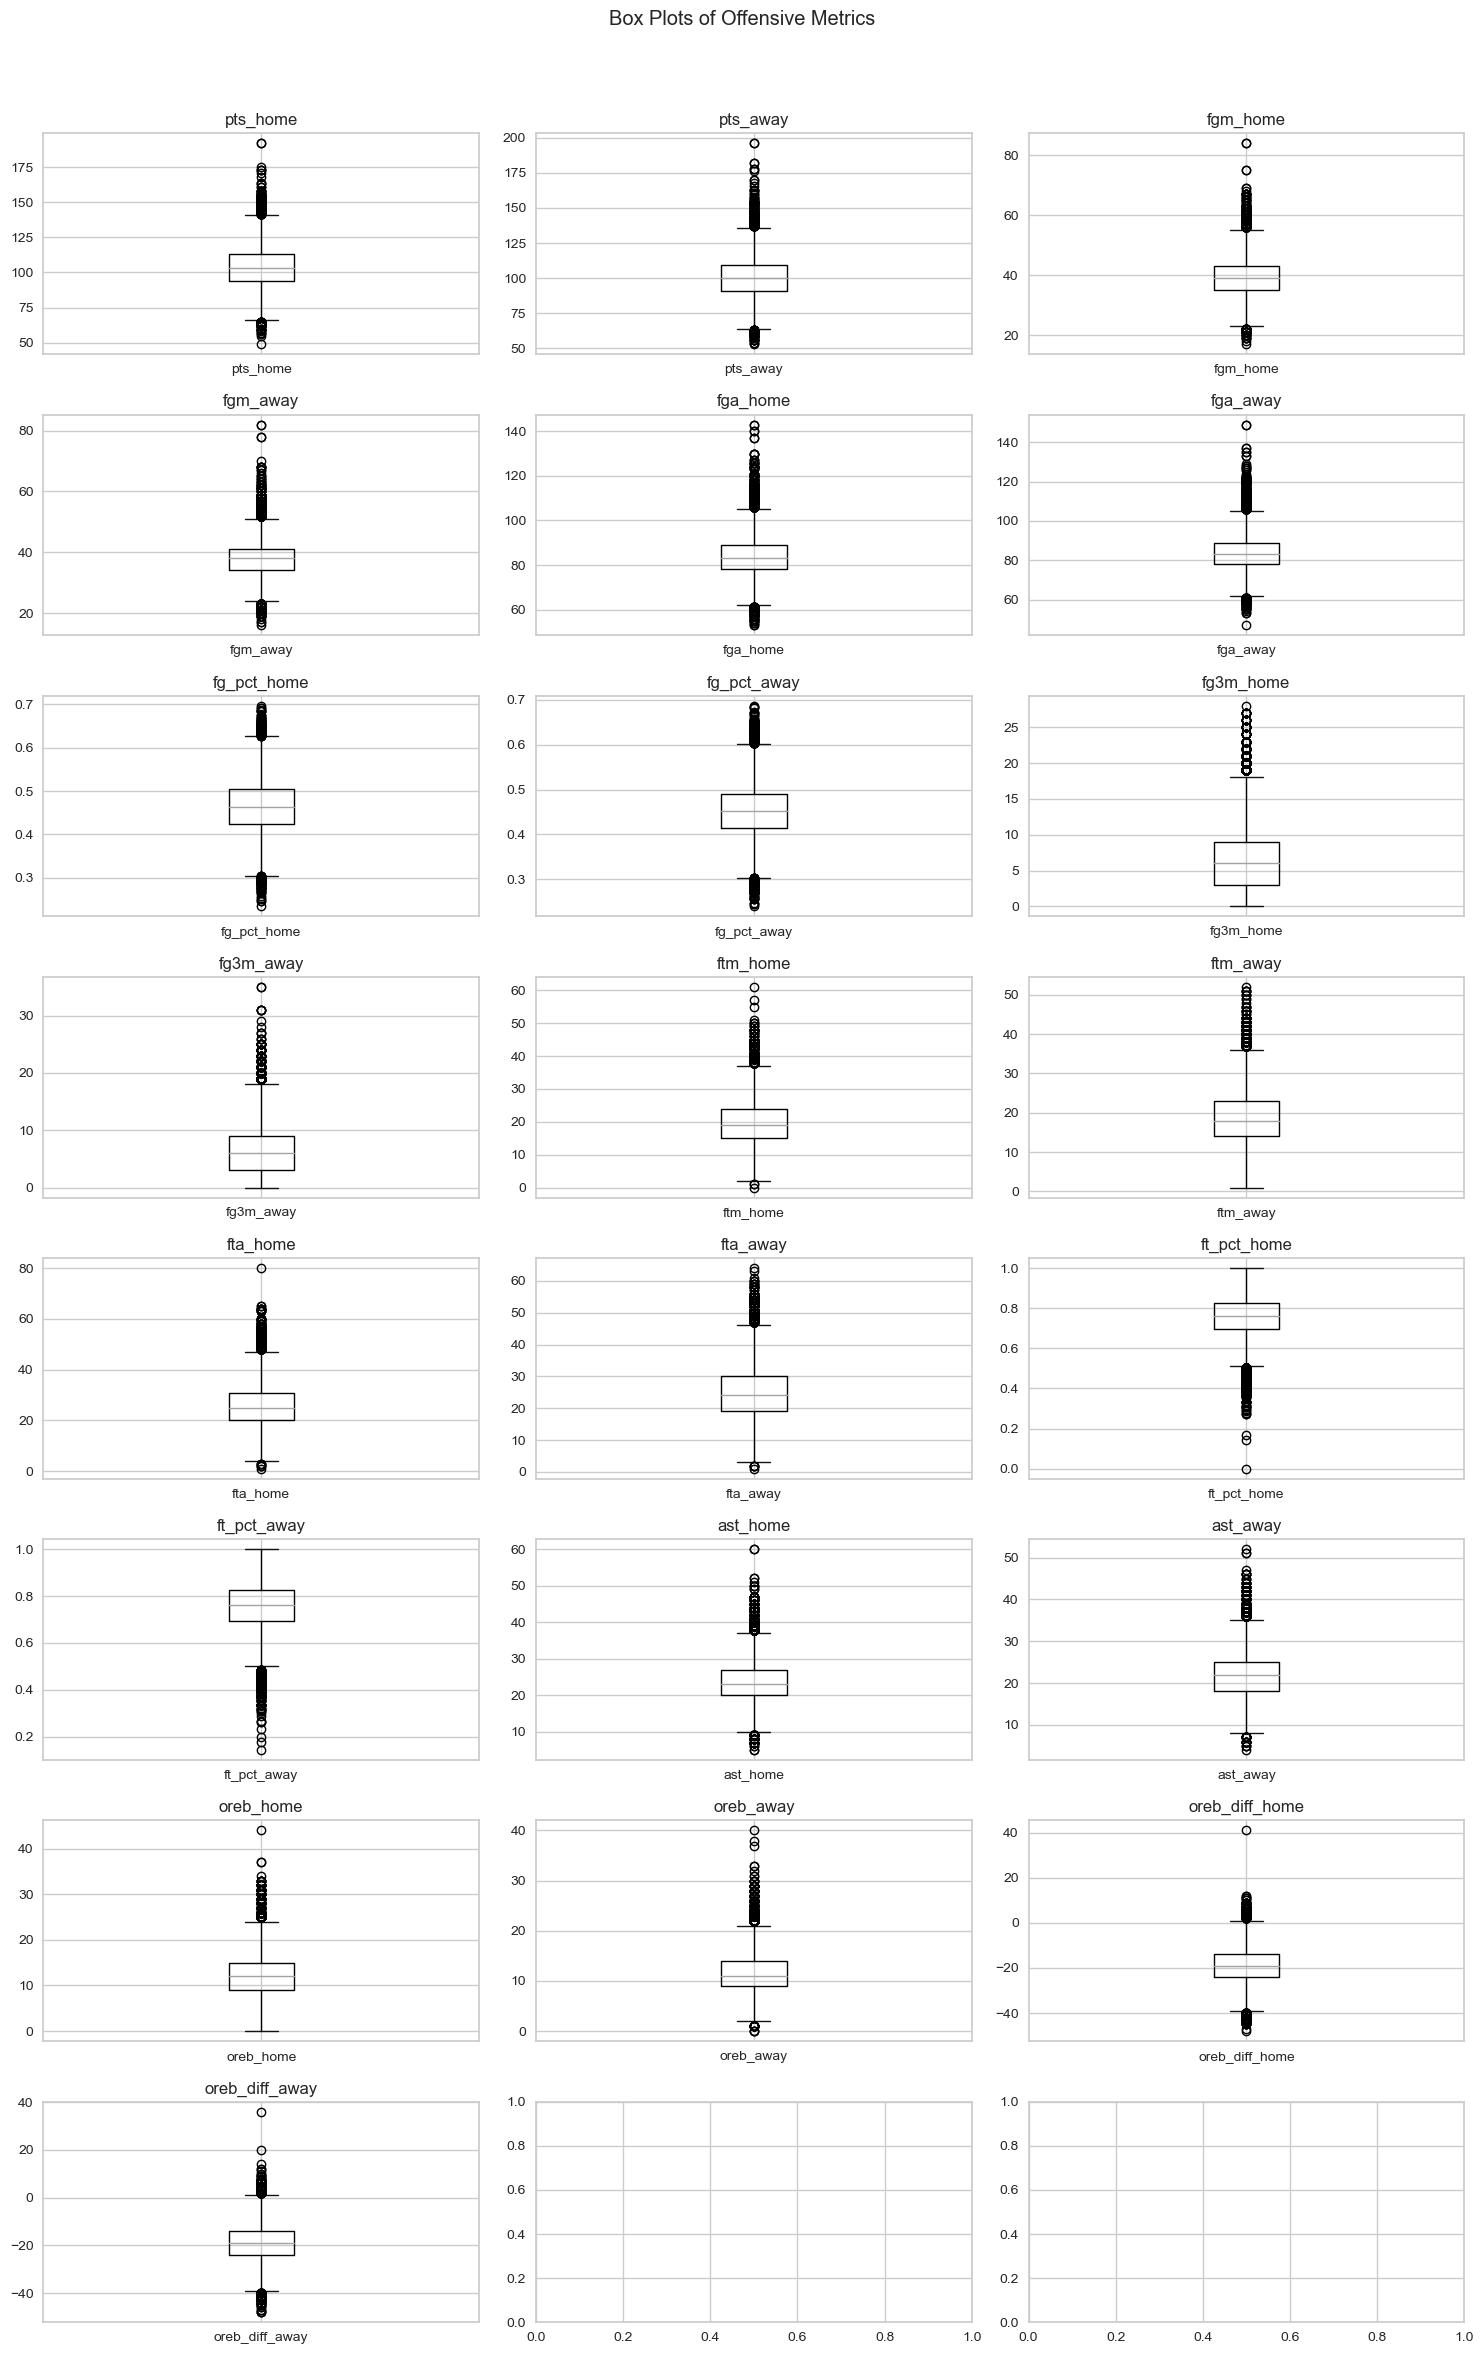

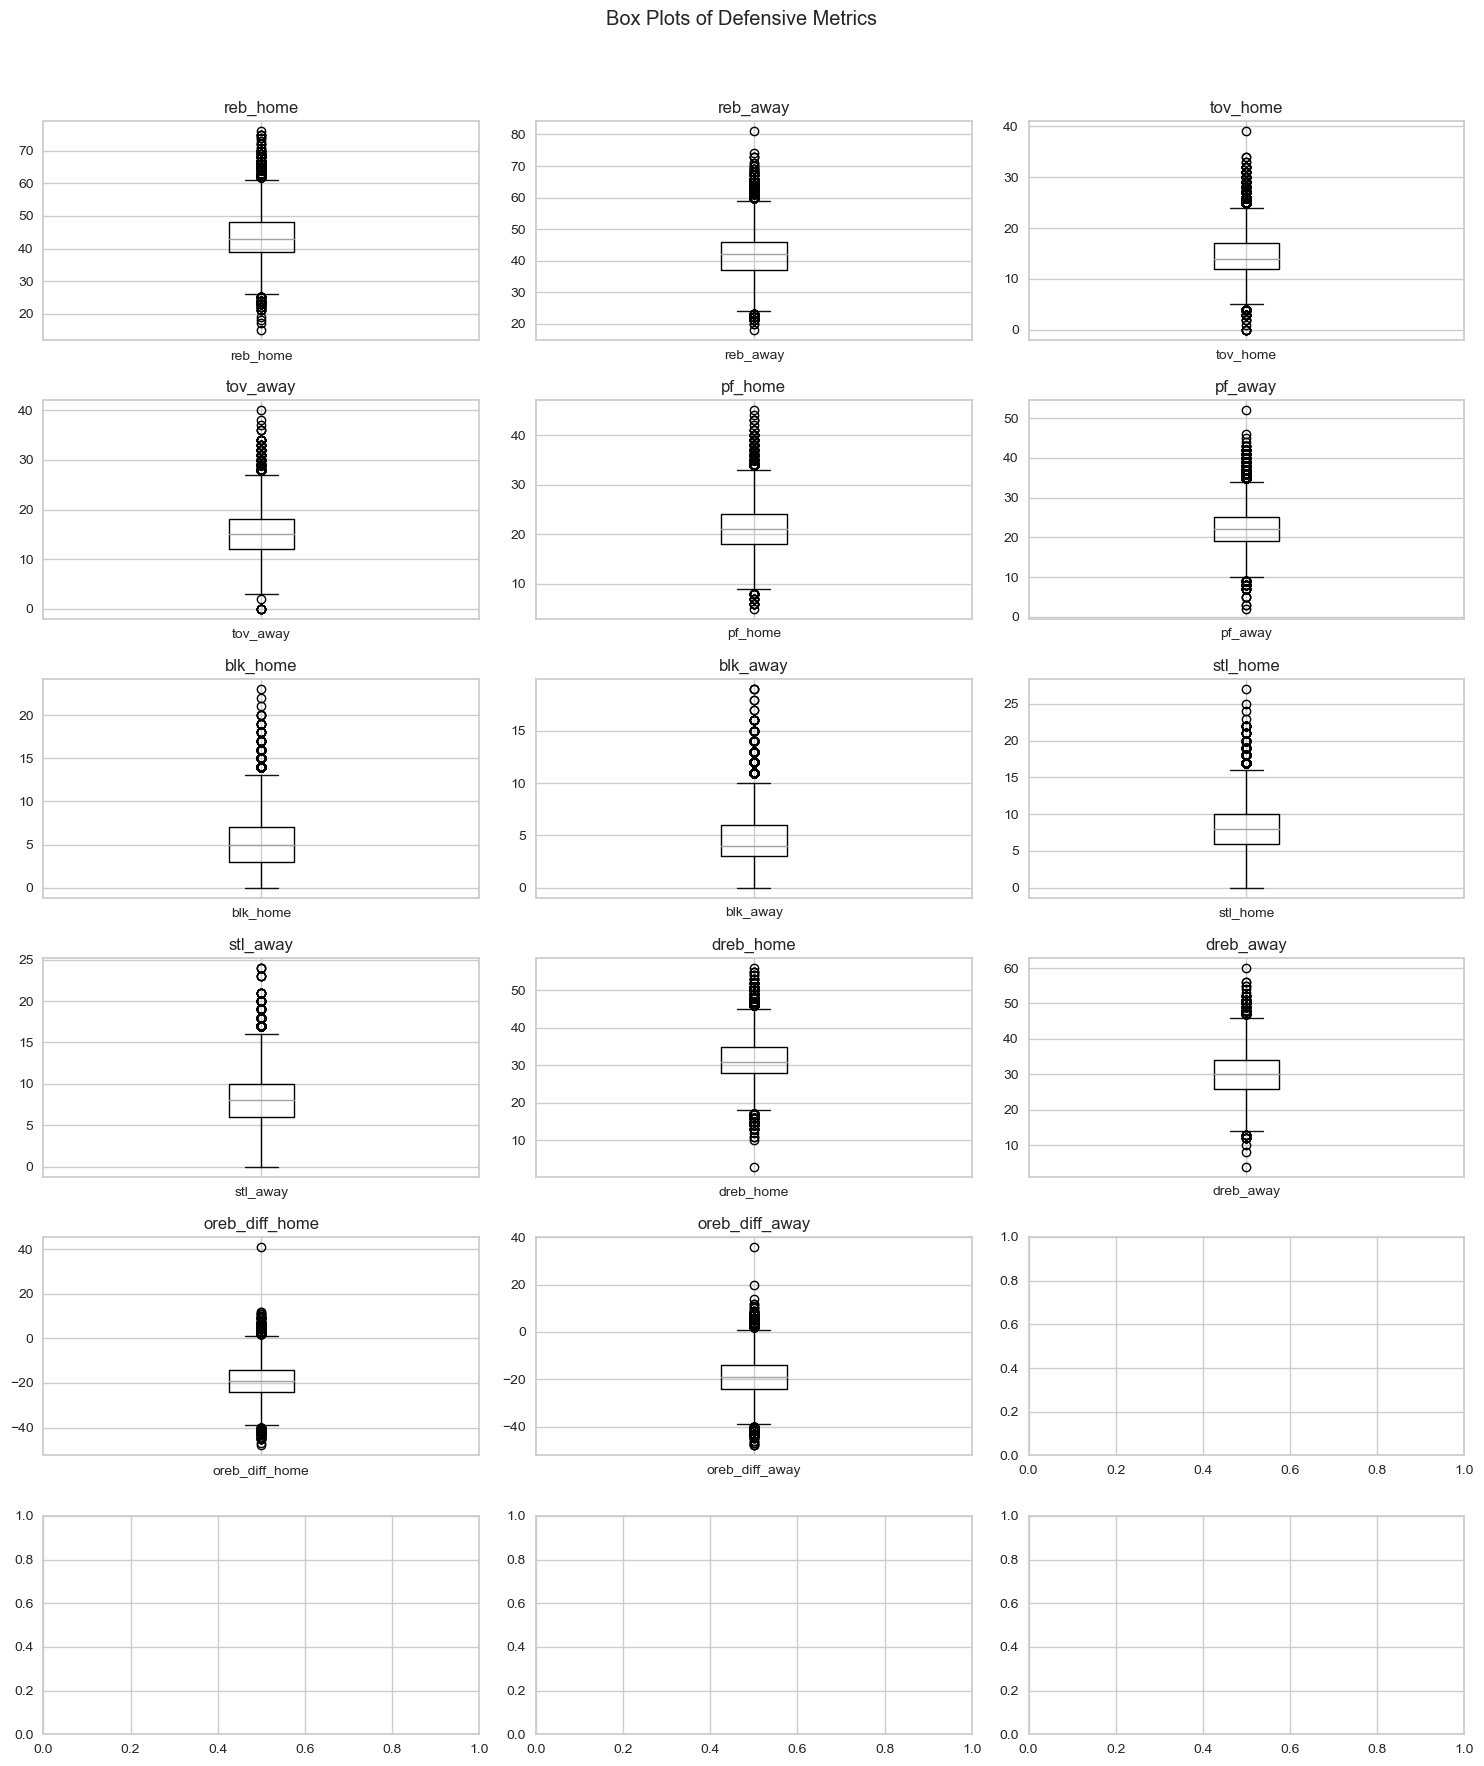

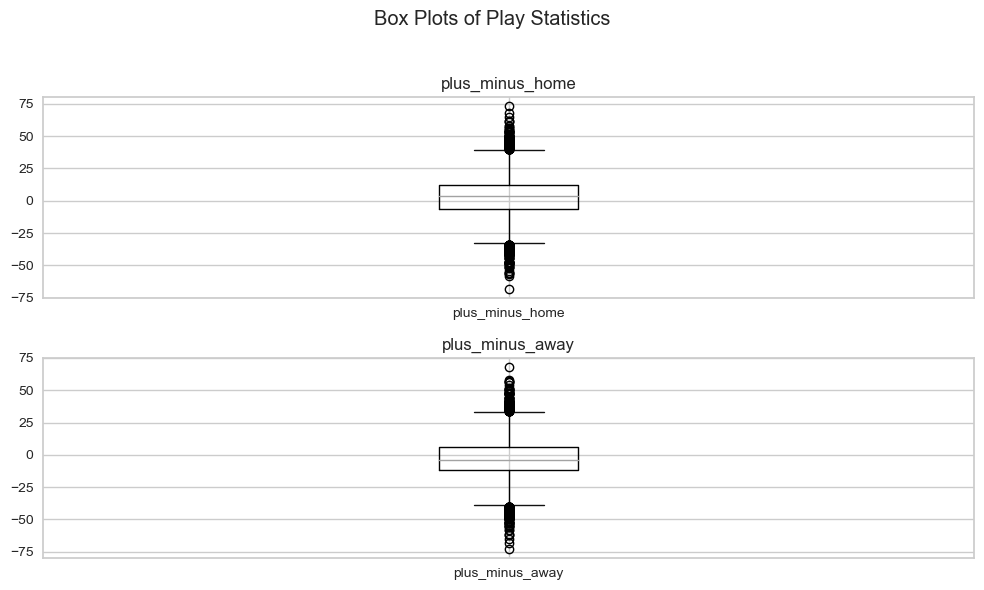

In [13]:
# Box plots for numerical features to spot outliers
# Selecting a subset of key columns for box plots
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Calculate the difference between offensive and defensive rebounds
recent_data['oreb_diff_home'] = recent_data['oreb_home'] - recent_data['dreb_home']
recent_data['oreb_diff_away'] = recent_data['oreb_away'] - recent_data['dreb_away']

# Add these new columns to the respective metrics lists
offensive_metrics.extend(['oreb_diff_home', 'oreb_diff_away'])
defensive_metrics.extend(['oreb_diff_home', 'oreb_diff_away'])

# Adjust layout dimensions to accommodate all metrics
offensive_layout = (8, 3)  # 24 plots (7 original rows + 1 row for 2 new metrics)
defensive_layout = (6, 3)  # 18 plots (5 original rows + 1 row for 2 new metrics)
play_stats_layout = (2, 1)  # 2 plots

# Visualize offensive metrics box plots
fig, axes = plt.subplots(nrows=offensive_layout[0], ncols=offensive_layout[1], figsize=(15, 24))
for ax, col in zip(axes.flatten(), offensive_metrics):
    recent_data.boxplot(column=col, ax=ax)
    ax.set_title(col)
plt.suptitle('Box Plots of Offensive Metrics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize defensive metrics box plots
fig, axes = plt.subplots(nrows=defensive_layout[0], ncols=defensive_layout[1], figsize=(15, 18))
for ax, col in zip(axes.flatten(), defensive_metrics):
    recent_data.boxplot(column=col, ax=ax)
    ax.set_title(col)
plt.suptitle('Box Plots of Defensive Metrics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize additional play statistics box plots
fig, axes = plt.subplots(nrows=play_stats_layout[0], ncols=play_stats_layout[1], figsize=(10, 6))
for ax, col in zip(axes.flatten(), play_stats):
    recent_data.boxplot(column=col, ax=ax)
    ax.set_title(col)
plt.suptitle('Box Plots of Play Statistics')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

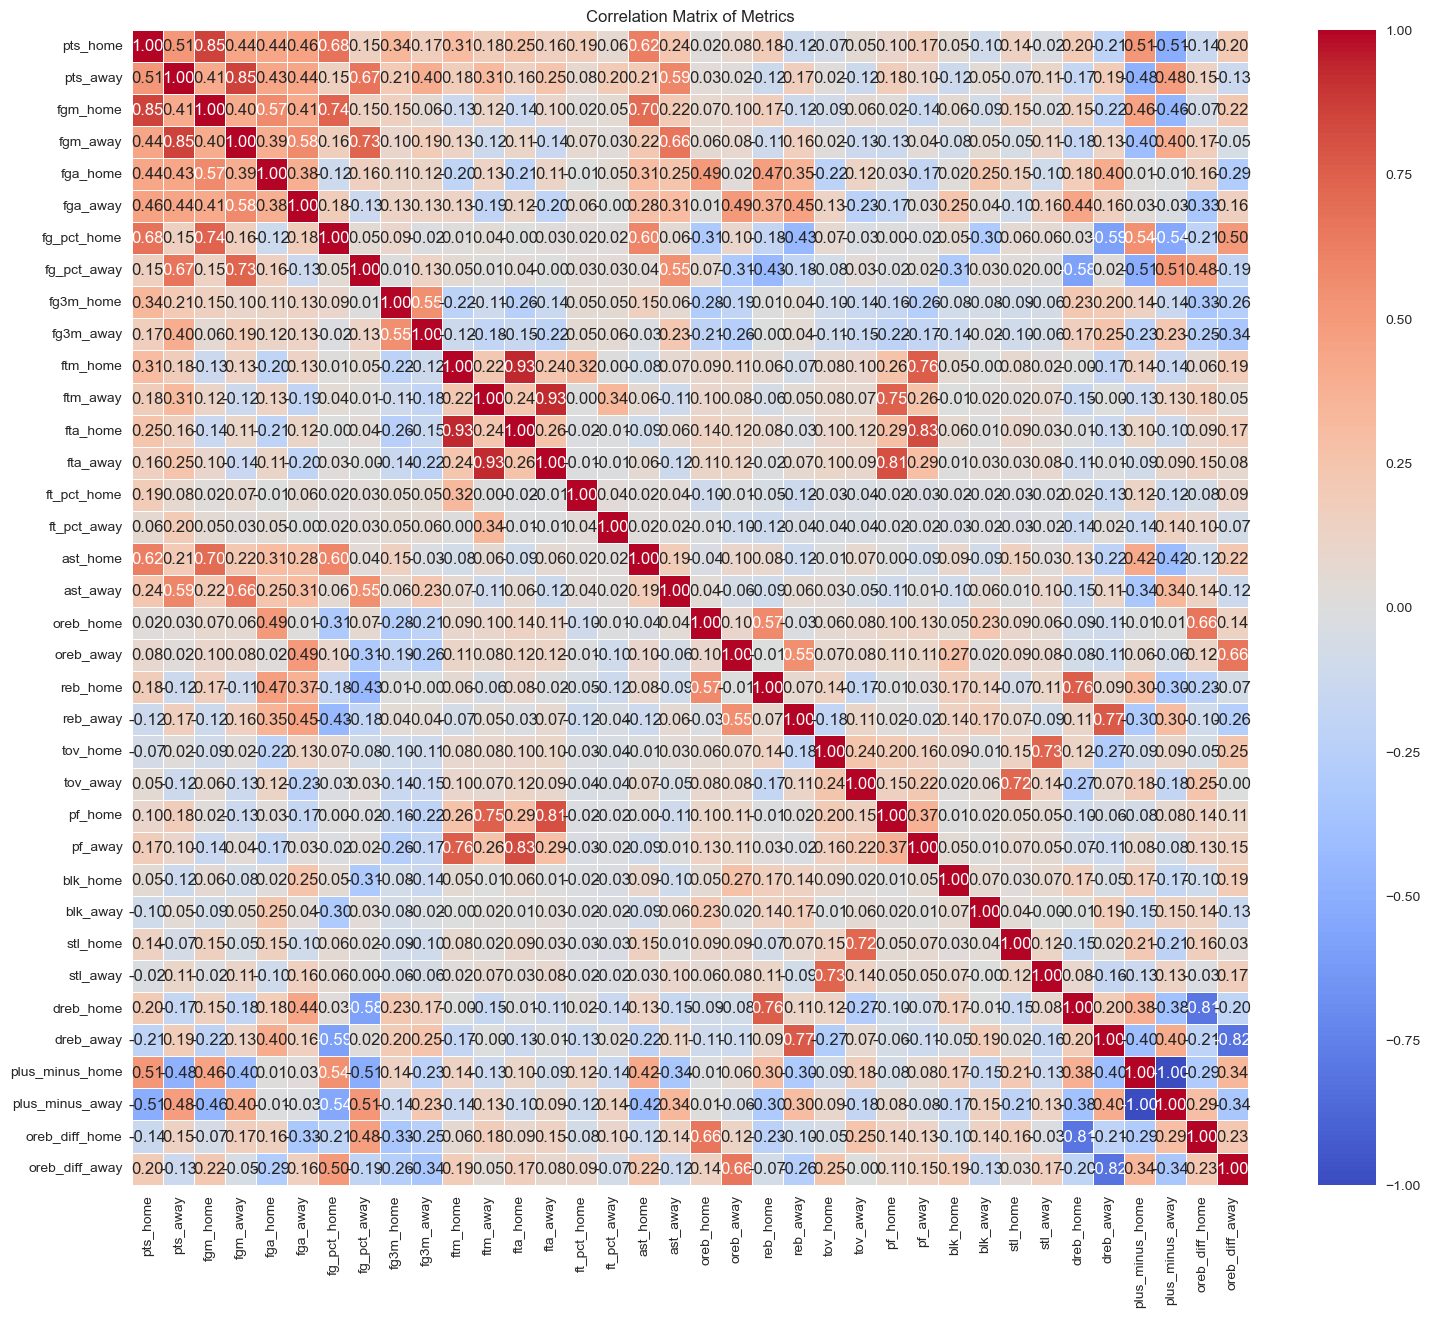

In [14]:
# Correlation matrix
# Selecting key variables that are likely to influence game outcomes
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Calculate the difference between offensive and defensive rebounds
recent_data['oreb_diff_home'] = recent_data['oreb_home'] - recent_data['dreb_home']
recent_data['oreb_diff_away'] = recent_data['oreb_away'] - recent_data['dreb_away']

# Combine all numerical metrics for correlation matrix
all_metrics = offensive_metrics + defensive_metrics + play_stats + ['oreb_diff_home', 'oreb_diff_away']

# Calculate the correlation matrix
correlation_matrix = recent_data[all_metrics].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

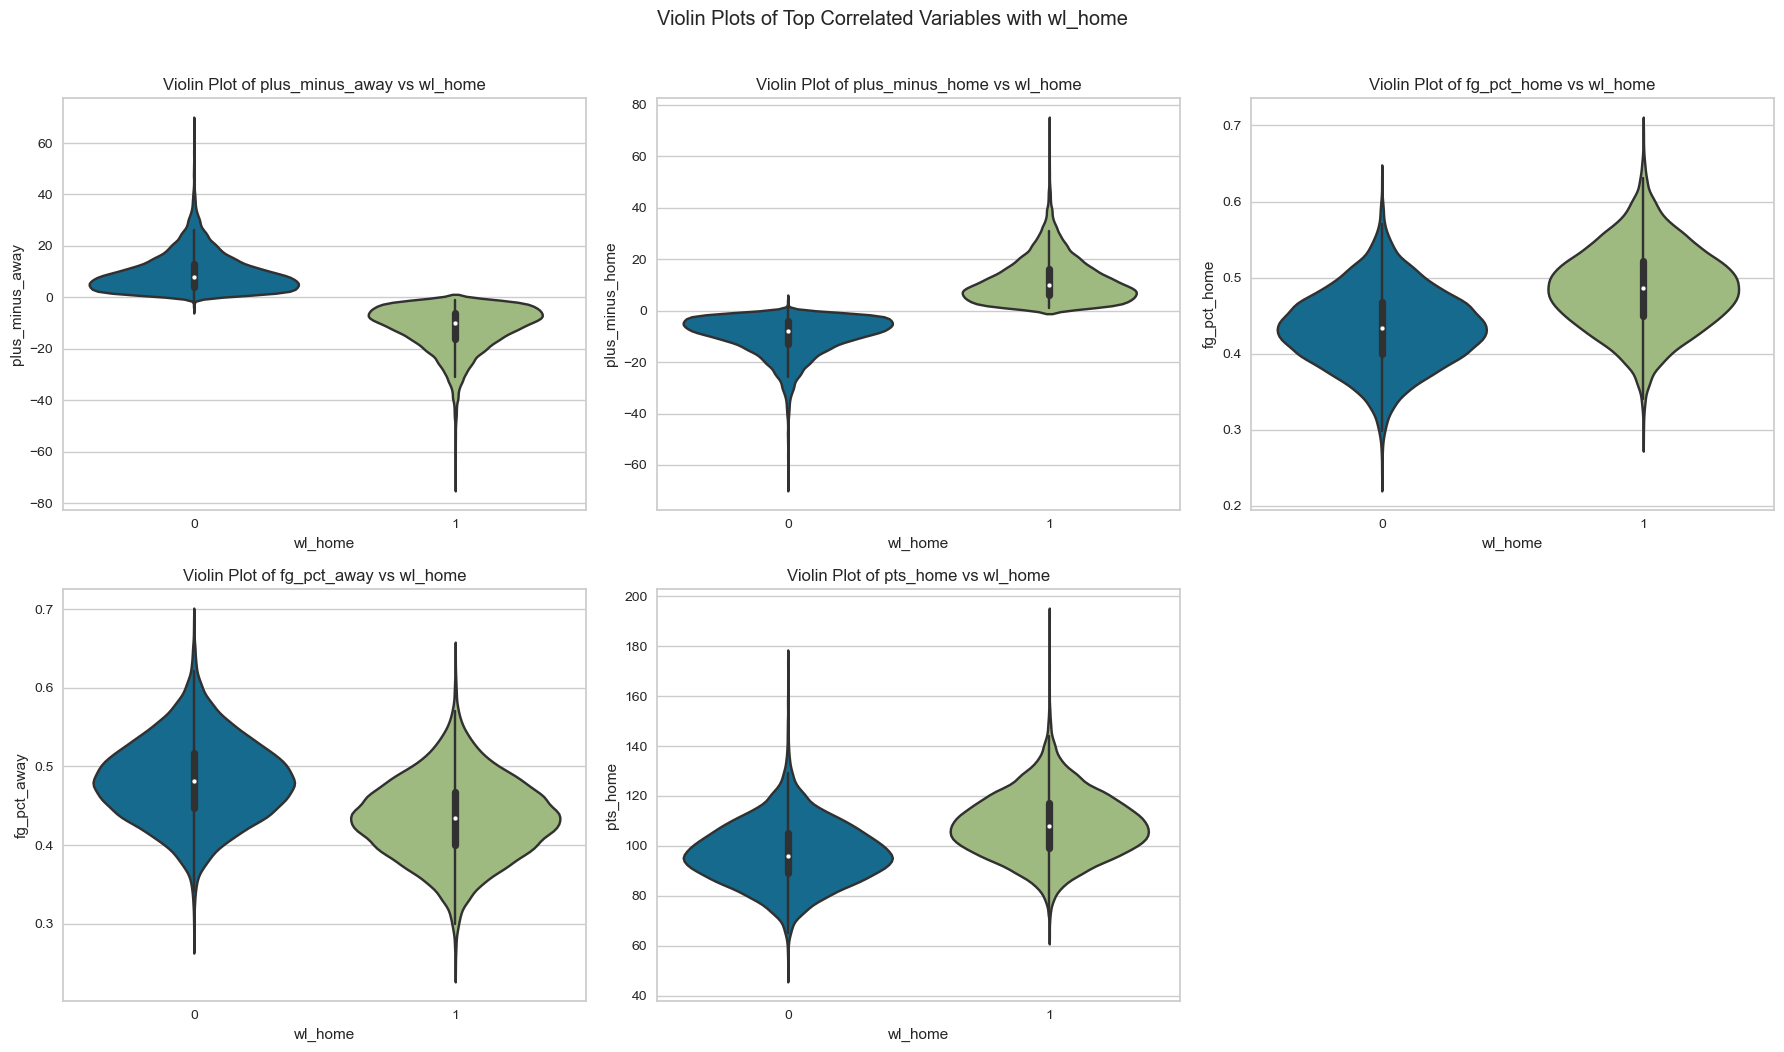

In [15]:
# Violin plot
# Selecting key variables that are likely to influence game outcomes
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Combine all numerical metrics for correlation calculation
all_metrics = offensive_metrics + defensive_metrics + play_stats + ['wl_home']

# Calculate the correlation matrix
correlation_matrix = recent_data[all_metrics].corr()

# Select the top variables correlated with wl_home (excluding wl_home itself)
correlated_vars = correlation_matrix['wl_home'].abs().sort_values(ascending=False).index[1:6]

# Plot violin plots for the top correlated variables against wl_home
plt.figure(figsize=(18, 10))
for i, var in enumerate(correlated_vars, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=recent_data['wl_home'], y=recent_data[var])
    plt.title(f'Violin Plot of {var} vs wl_home')
    plt.xlabel('wl_home')
    plt.ylabel(var)

plt.tight_layout()
plt.suptitle('Violin Plots of Top Correlated Variables with wl_home', y=1.05)
plt.show()

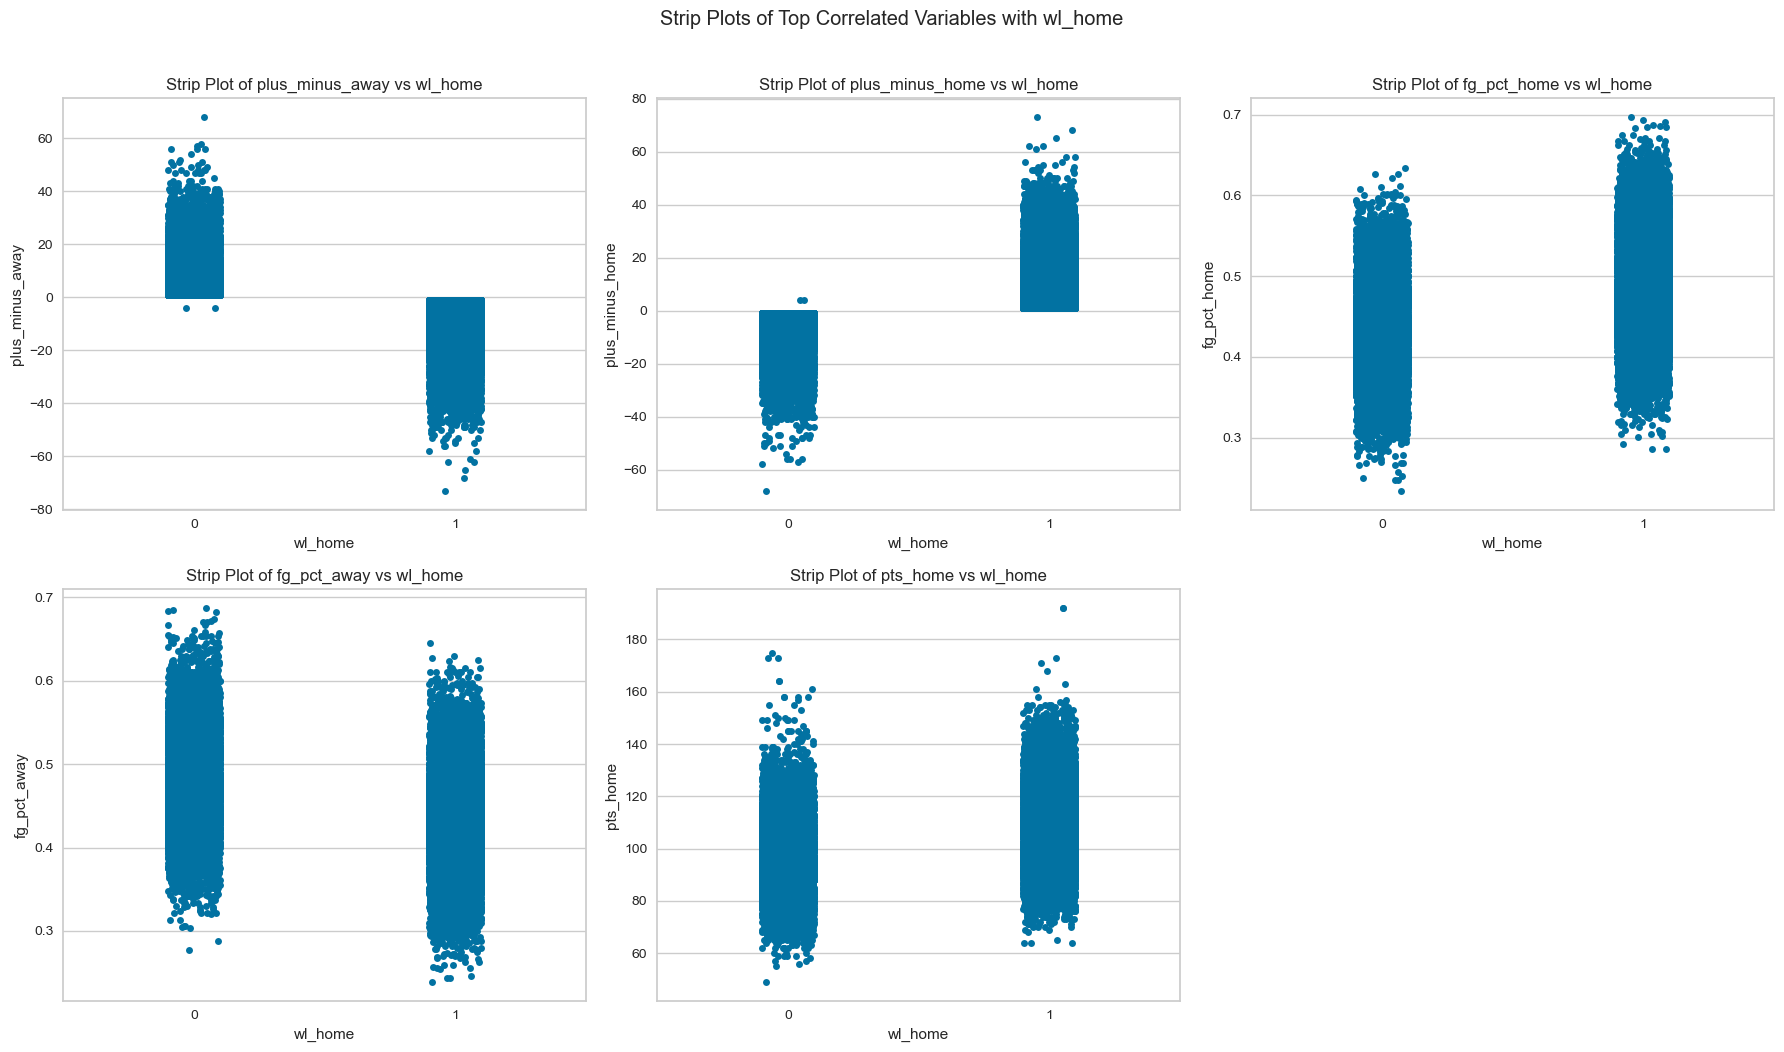

In [16]:
# Strip plot
# Selecting key variables that are likely to influence game outcomes
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Combine all numerical metrics for correlation calculation
all_metrics = offensive_metrics + defensive_metrics + play_stats + ['wl_home']

# Calculate the correlation matrix
correlation_matrix = recent_data[all_metrics].corr()

# Select the top variables correlated with wl_home (excluding wl_home itself)
correlated_vars = correlation_matrix['wl_home'].abs().sort_values(ascending=False).index[1:6]

# Plot strip plots for the top correlated variables against wl_home
plt.figure(figsize=(18, 10))
for i, var in enumerate(correlated_vars, 1):
    plt.subplot(2, 3, i)
    sns.stripplot(x=recent_data['wl_home'], y=recent_data[var], jitter=True)
    plt.title(f'Strip Plot of {var} vs wl_home')
    plt.xlabel('wl_home')
    plt.ylabel(var)

plt.tight_layout()
plt.suptitle('Strip Plots of Top Correlated Variables with wl_home', y=1.05)
plt.show()

In [17]:
sample_data = recent_data.sample(1000)

In [18]:
# swarm plot and boxen plot 

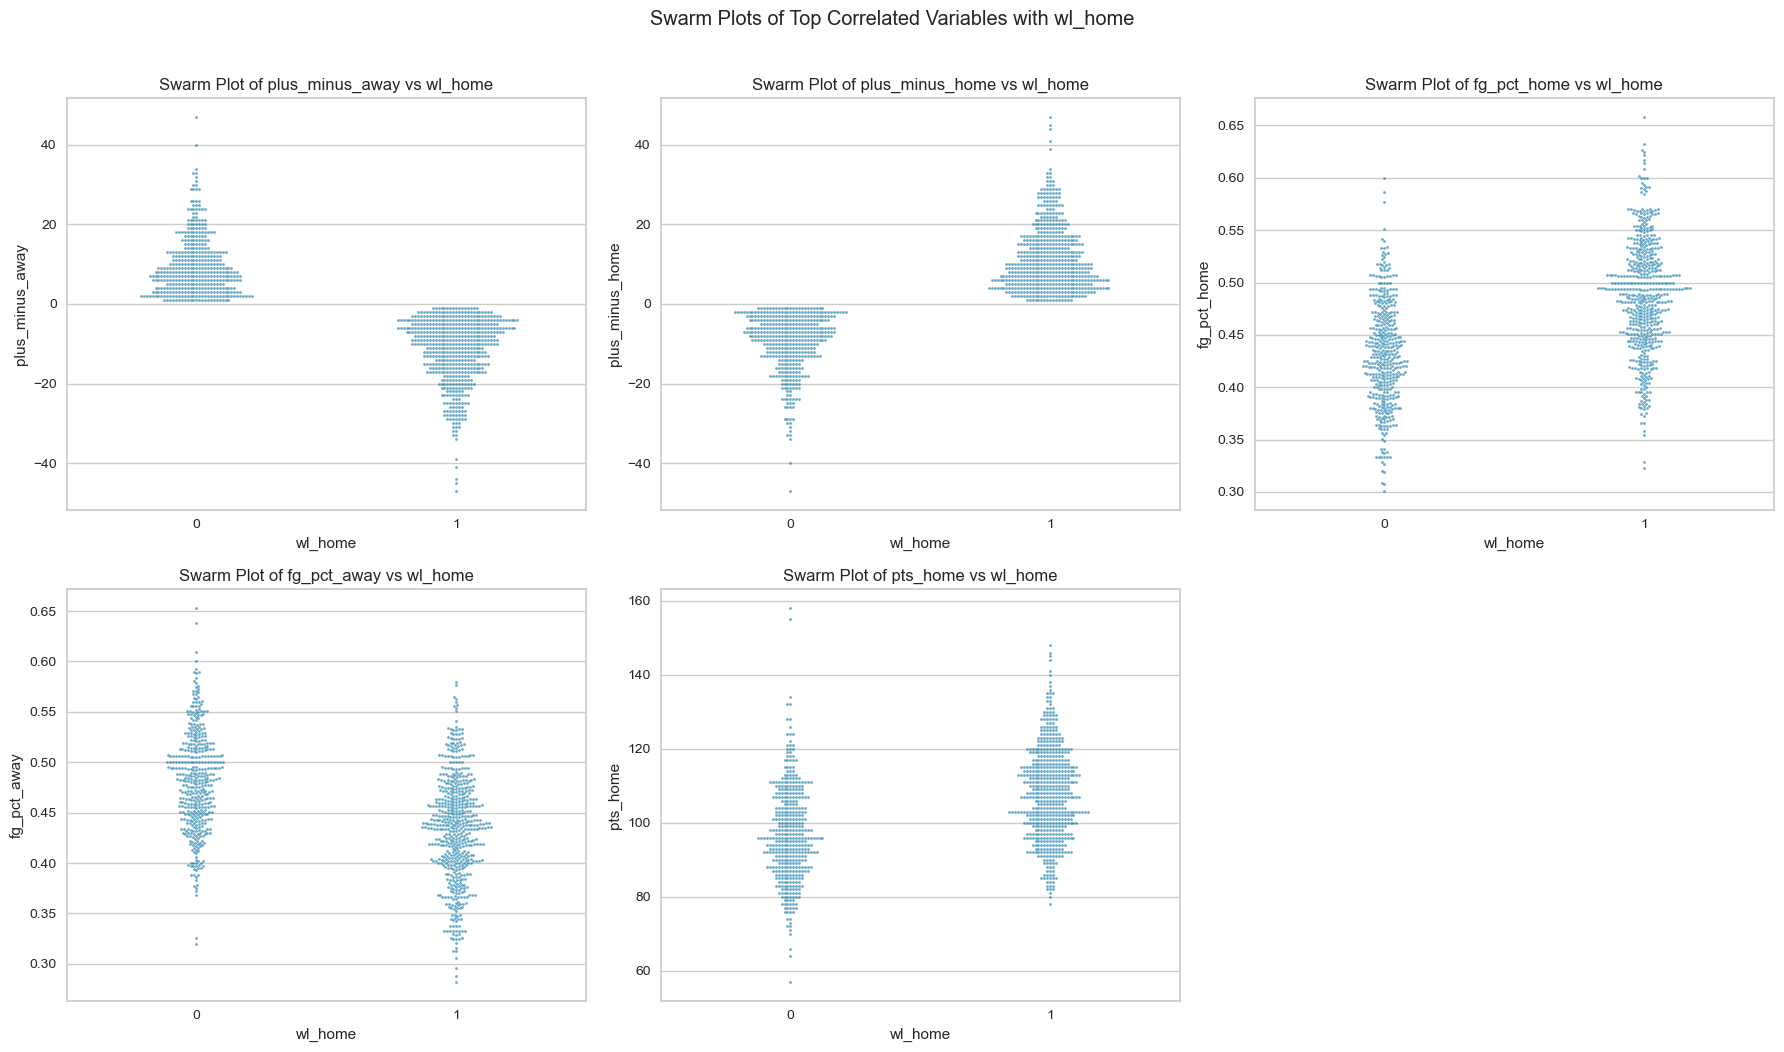

In [19]:
# Swarm plot
# Taking a sample size because the datset is too big for sawrm plot trial and error to find sample that will show, went from 10k to 1k
# Sample the data
sample_data = recent_data.sample(1000, random_state=42)

# Selecting key variables that are likely to influence game outcomes
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Combine all numerical metrics for correlation calculation
all_metrics = offensive_metrics + defensive_metrics + play_stats + ['wl_home']

# Calculate the correlation matrix
correlation_matrix = sample_data[all_metrics].corr()

# Select the top variables correlated with wl_home (excluding wl_home itself)
correlated_vars = correlation_matrix['wl_home'].abs().sort_values(ascending=False).index[1:6]

# Plot swarm plots for the top correlated variables against wl_home
plt.figure(figsize=(18, 10))
for i, var in enumerate(correlated_vars, 1):
    plt.subplot(2, 3, i)
    sns.swarmplot(x='wl_home', y=var, data=sample_data, size=2, alpha=0.6)
    plt.title(f'Swarm Plot of {var} vs wl_home')
    plt.xlabel('wl_home')
    plt.ylabel(var)
plt.tight_layout()
plt.suptitle('Swarm Plots of Top Correlated Variables with wl_home', y=1.05)
plt.show()

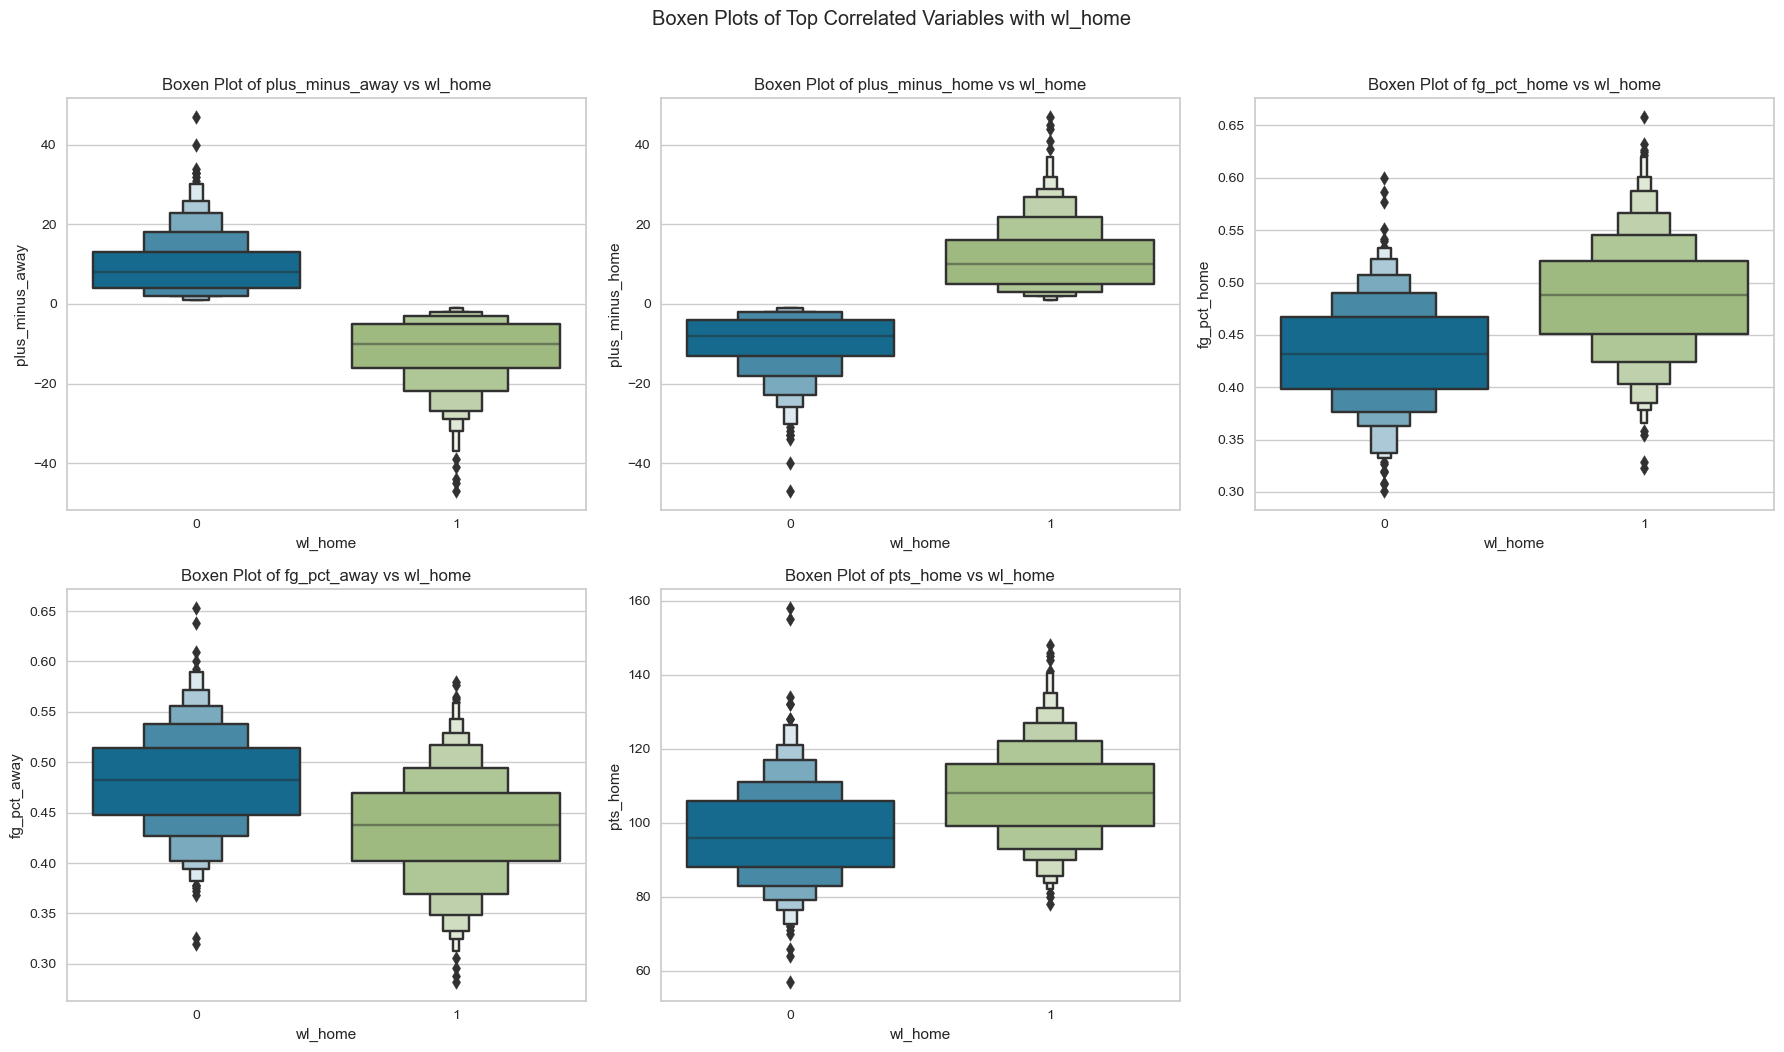

In [20]:
# Boxen plot
# Selecting key variables that are likely to influence game outcomes
offensive_metrics = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 
    'fga_home', 'fga_away', 'fg_pct_home', 'fg_pct_away', 
    'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away', 
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 
    'ast_home', 'ast_away', 'oreb_home', 'oreb_away'
]

defensive_metrics = [
    'reb_home', 'reb_away', 'tov_home', 'tov_away', 
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 
    'stl_home', 'stl_away', 'dreb_home', 'dreb_away'
]

play_stats = ['plus_minus_home', 'plus_minus_away']

# Combine all numerical metrics for correlation calculation
all_metrics = offensive_metrics + defensive_metrics + play_stats + ['wl_home']

# Calculate the correlation matrix
correlation_matrix = sample_data[all_metrics].corr()

# Select the top variables correlated with wl_home (excluding wl_home itself)
correlated_vars = correlation_matrix['wl_home'].abs().sort_values(ascending=False).index[1:6]

# Plot boxen plots for the top correlated variables against wl_home
plt.figure(figsize=(18, 10))
for i, var in enumerate(correlated_vars, 1):
    plt.subplot(2, 3, i)
    sns.boxenplot(x='wl_home', y=var, data=sample_data)
    plt.title(f'Boxen Plot of {var} vs wl_home')
    plt.xlabel('wl_home')
    plt.ylabel(var)
plt.tight_layout()
plt.suptitle('Boxen Plots of Top Correlated Variables with wl_home', y=1.05)
plt.show()

In [21]:
recent_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46154 entries, 14166 to 65695
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season_id               46154 non-null  int64  
 1   team_id_home            46154 non-null  int64  
 2   team_abbreviation_home  46154 non-null  object 
 3   team_name_home          46154 non-null  object 
 4   game_id                 46154 non-null  int64  
 5   game_date               46154 non-null  object 
 6   matchup_home            46154 non-null  object 
 7   wl_home                 46154 non-null  int64  
 8   min                     46154 non-null  int64  
 9   fgm_home                46154 non-null  float64
 10  fga_home                46154 non-null  float64
 11  fg_pct_home             46154 non-null  float64
 12  fg3m_home               46154 non-null  float64
 13  fg3a_home               46154 non-null  float64
 14  fg3_pct_home            46154 non-null 

# 3. Preprocessing

In [22]:
LAL = recent_data[recent_data['team_abbreviation_home']=='LAL']

In [23]:
LAL['PREDICTION_OF_NEXT_GAME'] = LAL.shift(-1)['wl_home']

In [24]:
LAL

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,oreb_diff_home,oreb_diff_away,PREDICTION_OF_NEXT_GAME
14166,41979,1610612747,LAL,Los Angeles Lakers,47900044,1980-05-07 00:00:00,LAL vs. PHL,0,240,48.0,...,11.0,20.0,21.0,107.0,3,0,Playoffs,-22.0,-24.0,1.0
16156,41981,1610612747,LAL,Los Angeles Lakers,48100042,1982-06-01 00:00:00,LAL vs. PHL,1,240,50.0,...,8.0,11.0,36.0,108.0,-21,0,Playoffs,-14.0,-15.0,1.0
16157,41981,1610612747,LAL,Los Angeles Lakers,48100043,1982-06-03 00:00:00,LAL vs. PHL,1,240,45.0,...,7.0,16.0,23.0,101.0,-10,0,Playoffs,-17.0,-18.0,1.0
17131,41982,1610612747,LAL,Los Angeles Lakers,48200027,1983-05-03 00:00:00,LAL vs. POR,1,240,49.0,...,6.0,14.0,23.0,108.0,-8,0,Playoffs,-27.0,-16.0,0.0
17135,41982,1610612747,LAL,Los Angeles Lakers,48200031,1983-05-10 00:00:00,LAL vs. SAN,0,240,48.0,...,10.0,24.0,19.0,122.0,9,0,Playoffs,-15.0,-21.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65665,42022,1610612747,LAL,Los Angeles Lakers,42200233,2023-05-06 00:00:00,LAL vs. GSW,1,240,42.0,...,6.0,19.0,22.0,97.0,-30,1,Playoffs,-32.0,-14.0,1.0
65669,42022,1610612747,LAL,Los Angeles Lakers,42200234,2023-05-08 00:00:00,LAL vs. GSW,1,240,39.0,...,2.0,16.0,22.0,101.0,-3,1,Playoffs,-26.0,-22.0,1.0
65677,42022,1610612747,LAL,Los Angeles Lakers,42200236,2023-05-12 00:00:00,LAL vs. GSW,1,240,39.0,...,2.0,11.0,30.0,101.0,-21,1,Playoffs,-34.0,-13.0,0.0
65684,42022,1610612747,LAL,Los Angeles Lakers,42200313,2023-05-20 00:00:00,LAL vs. DEN,0,240,38.0,...,1.0,6.0,19.0,119.0,11,1,Playoffs,-23.0,-29.0,0.0


In [25]:
recent_data[recent_data['team_abbreviation_home']=='LAL']['PREDICTION_OF_NEXT_GAME']=recent_data[recent_data['team_abbreviation_home']=='LAL'].shift(-1)['wl_home']

In [26]:
recent_data.columns

Index(['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home',
       'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home',
       'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home',
       'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home',
       'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'pts_home', 'plus_minus_home', 'video_available_home', 'team_id_away',
       'team_abbreviation_away', 'team_name_away', 'matchup_away', 'wl_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'video_available_away',
       'season_type', 'oreb_diff_home', 'oreb_diff_away'],
      dtype='object')

In [27]:
recent_data[recent_data['team_abbreviation_home']=='LAL'].shift(-1)['wl_home']

14166    1.0
16156    1.0
16157    1.0
17131    0.0
17135    0.0
        ... 
65665    1.0
65669    1.0
65677    0.0
65684    0.0
65686    NaN
Name: wl_home, Length: 1767, dtype: float64

In [28]:
# find the predictors drop all variables that dont need
# List of columns to drop
columns_to_drop = [
    'season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home', 
    'game_id', 'matchup_home', 'team_id_away', 'team_abbreviation_away', 
    'team_name_away', 'matchup_away', 'wl_away', 'video_available_home', 'video_available_away'
]

# Drop the unnecessary columns
cleaned_data = recent_data.drop(columns=columns_to_drop)

# Display the remaining columns to verify
print(cleaned_data.columns)

Index(['game_date', 'wl_home', 'min', 'fgm_home', 'fga_home', 'fg_pct_home',
       'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home',
       'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home',
       'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home',
       'plus_minus_home', 'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away',
       'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away',
       'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away',
       'blk_away', 'tov_away', 'pf_away', 'pts_away', 'plus_minus_away',
       'season_type', 'oreb_diff_home', 'oreb_diff_away'],
      dtype='object')


In [29]:
# find the predictors drop all variables that dont need
# List of columns to drop
columns_to_drop = ['game_date',
    'season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home', 
    'game_id', 'matchup_home', 'team_id_away', 'team_abbreviation_away', 
    'team_name_away', 'matchup_away', 'wl_away', 'video_available_home', 'video_available_away'
]

# Drop the unnecessary columns
LAL_cleaned_data = LAL.drop(columns=columns_to_drop)

# Display the remaining columns to verify
print(LAL_cleaned_data.columns)

Index(['wl_home', 'min', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home',
       'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
       'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home',
       'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'season_type',
       'oreb_diff_home', 'oreb_diff_away', 'PREDICTION_OF_NEXT_GAME'],
      dtype='object')


In [30]:
LAL_cleaned_data

,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,...,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,season_type,oreb_diff_home,oreb_diff_away,PREDICTION_OF_NEXT_GAME
14166,0,240,48.0,95.0,0.505,0.0,1.0,0.000,8.0,12.0,...,14.0,11.0,20.0,21.0,107.0,3,Playoffs,-22.0,-24.0,1.0
16156,1,240,50.0,91.0,0.549,1.0,1.0,1.000,28.0,47.0,...,10.0,8.0,11.0,36.0,108.0,-21,Playoffs,-14.0,-15.0,1.0
16157,1,240,45.0,97.0,0.464,0.0,1.0,0.000,21.0,29.0,...,3.0,7.0,16.0,23.0,101.0,-10,Playoffs,-17.0,-18.0,1.0
17131,1,240,49.0,93.0,0.527,0.0,5.0,0.000,18.0,25.0,...,6.0,6.0,14.0,23.0,108.0,-8,Playoffs,-27.0,-16.0,0.0
17135,0,240,48.0,99.0,0.485,2.0,6.0,0.333,15.0,23.0,...,9.0,10.0,24.0,19.0,122.0,9,Playoffs,-15.0,-21.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65665,1,240,42.0,80.0,0.525,15.0,31.0,0.484,28.0,37.0,...,5.0,6.0,19.0,22.0,97.0,-30,Playoffs,-32.0,-14.0,1.0
65669,1,240,39.0,86.0,0.453,6.0,25.0,0.240,20.0,20.0,...,9.0,2.0,16.0,22.0,101.0,-3,Playoffs,-26.0,-22.0,1.0
65677,1,240,39.0,75.0,0.520,13.0,26.0,0.500,31.0,42.0,...,3.0,2.0,11.0,30.0,101.0,-21,Playoffs,-34.0,-13.0,0.0
65684,0,240,38.0,84.0,0.452,10.0,32.0,0.313,22.0,29.0,...,7.0,1.0,6.0,19.0,119.0,11,Playoffs,-23.0,-29.0,0.0


In [31]:
# Define the target variable (y) and feature variables (X)
y = cleaned_data['wl_home']
X = cleaned_data.drop(columns=['wl_home'])

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46154 entries, 14166 to 65695
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_date        46154 non-null  object 
 1   min              46154 non-null  int64  
 2   fgm_home         46154 non-null  float64
 3   fga_home         46154 non-null  float64
 4   fg_pct_home      46154 non-null  float64
 5   fg3m_home        46154 non-null  float64
 6   fg3a_home        46154 non-null  float64
 7   fg3_pct_home     46154 non-null  float64
 8   ftm_home         46154 non-null  float64
 9   fta_home         46154 non-null  float64
 10  ft_pct_home      46154 non-null  float64
 11  oreb_home        46154 non-null  float64
 12  dreb_home        46154 non-null  float64
 13  reb_home         46154 non-null  float64
 14  ast_home         46154 non-null  float64
 15  stl_home         46154 non-null  float64
 16  blk_home         46154 non-null  float64
 17  tov_home     

# 4. Model Training

In [33]:
# Drop the game_date column
if 'game_date' in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=['game_date'])

# Define the target variable (y) and feature variables (X)
y = cleaned_data['wl_home']
X = cleaned_data.drop(columns=['wl_home'])

# Verify the columns to ensure 'game_date' is not present
print("Columns in cleaned_data:", cleaned_data.columns)

# Identify categorical columns
categorical_cols = ['season_type']

# Convert categorical columns to numerical format
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Verify data types after conversion
print("Data types in X after label encoding:\n", X.dtypes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Columns in cleaned_data: Index(['wl_home', 'min', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home',
       'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
       'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home',
       'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'season_type',
       'oreb_diff_home', 'oreb_diff_away'],
      dtype='object')
Data types in X after label encoding:
 min                  int64
fgm_home           float64
fga_home           float64
fg_pct_home        float64
fg3m_home          float64
fg3a_home          float64
fg3_pct_home       float64
ftm_home           float64
fta_home           float64
ft_pct_home        float64
oreb_home      

In [34]:
# Cross Validation
# Define the target variable (y) and feature variables (X)
y = cleaned_data['wl_home']
X = cleaned_data.drop(columns=['wl_home'])

# Identify categorical columns
categorical_cols = ['season_type']

# Convert categorical columns to numerical format
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [1.         1.         0.99978334 1.         0.99989166]
Mean Cross-Validation Score: 0.9999349992776002


In [35]:
X

,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,season_type,oreb_diff_home,oreb_diff_away
14166,240,48.0,95.0,0.505,0.0,1.0,0.000,8.0,12.0,0.667,...,34.0,14.0,11.0,20.0,21.0,107.0,3,2,-22.0,-24.0
14167,240,45.0,93.0,0.484,1.0,4.0,0.250,10.0,17.0,0.588,...,20.0,5.0,5.0,20.0,25.0,111.0,10,2,-11.0,-12.0
14170,240,47.0,89.0,0.528,0.0,6.0,0.000,13.0,22.0,0.591,...,27.0,14.0,4.0,17.0,22.0,123.0,16,2,-22.0,-18.0
14171,265,58.0,124.0,0.468,1.0,2.0,0.500,27.0,44.0,0.614,...,34.0,17.0,16.0,29.0,32.0,136.0,-8,1,0.0,-7.0
14172,265,58.0,124.0,0.468,1.0,2.0,0.500,27.0,44.0,0.614,...,34.0,17.0,16.0,29.0,32.0,136.0,-8,0,0.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65691,240,40.0,79.0,0.506,8.0,27.0,0.296,16.0,20.0,0.800,...,26.0,5.0,4.0,8.0,15.0,93.0,-11,2,-33.0,-21.0
65692,240,39.0,75.0,0.520,11.0,28.0,0.393,19.0,22.0,0.864,...,28.0,5.0,4.0,11.0,22.0,111.0,3,2,-20.0,-15.0
65693,240,34.0,92.0,0.370,11.0,35.0,0.314,15.0,19.0,0.789,...,28.0,3.0,5.0,14.0,18.0,109.0,15,2,-13.0,-32.0
65694,240,35.0,78.0,0.449,8.0,25.0,0.320,17.0,20.0,0.850,...,26.0,11.0,7.0,8.0,18.0,108.0,13,2,-21.0,-24.0


In [36]:
LAL_cleaned_data=LAL_cleaned_data.drop(columns=['season_type'])

# XGBoost model

In [37]:
# Define the target variable (y) and feature variables (X)
LAL_cleaned_data=LAL_cleaned_data.dropna()
y = LAL_cleaned_data['PREDICTION_OF_NEXT_GAME']
X = LAL_cleaned_data.drop(columns=['PREDICTION_OF_NEXT_GAME'])

# Identify categorical columns
# categorical_cols = ['season_type']

# # Convert categorical columns to numerical format
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col])
#     label_encoders[col] = le

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [0.6779661  0.62322946 0.62322946 0.62889518 0.45042493]
Mean Cross-Validation Score: 0.6007490277044221


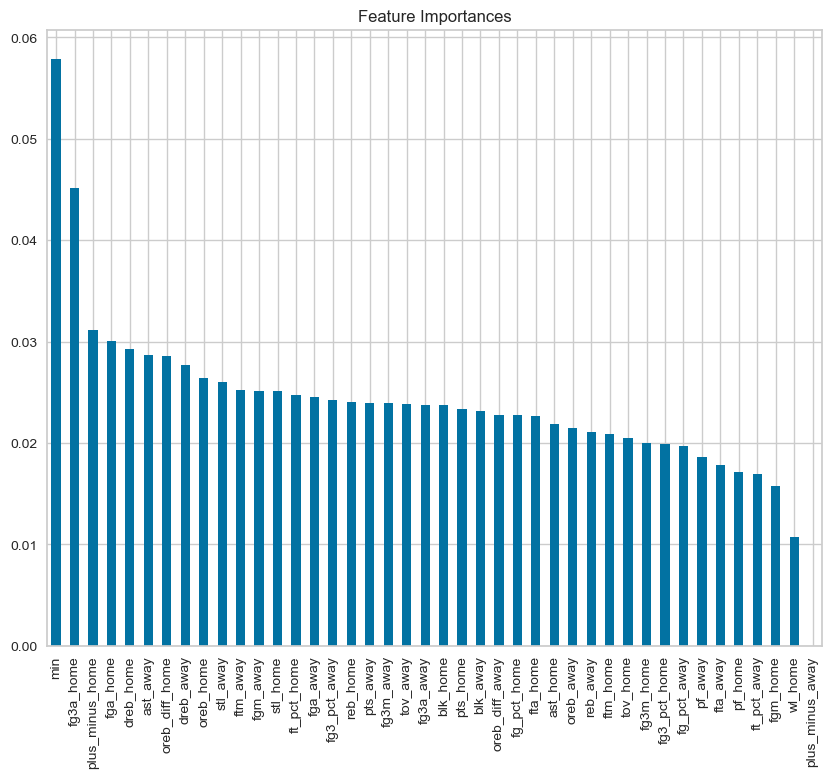

In [38]:
# Feature Importance
# Train the model on the full dataset
xgb_model.fit(X, y)

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [39]:
# Hyperparameter Tuning
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Score: 0.6704433895799405


In [40]:
# Evaluate on a holdout Test Set
# Split the data into training and holdout test sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Evaluate on the holdout test set
y_holdout_pred = xgb_model.predict(X_holdout)

# Calculate accuracy on the holdout set
holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
print("Holdout Test Accuracy:", holdout_accuracy)

# Generate classification report for the holdout set
holdout_report = classification_report(y_holdout, y_holdout_pred)
print("Holdout Test Classification Report:\n", holdout_report)

# Generate confusion matrix for the holdout set
holdout_conf_matrix = confusion_matrix(y_holdout, y_holdout_pred)
print("Holdout Test Confusion Matrix:\n", holdout_conf_matrix)


Holdout Test Accuracy: 0.6836158192090396
Holdout Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.38      0.43       114
         1.0       0.74      0.83      0.78       240

    accuracy                           0.68       354
   macro avg       0.62      0.60      0.61       354
weighted avg       0.66      0.68      0.67       354

Holdout Test Confusion Matrix:
 [[ 43  71]
 [ 41 199]]


# SHAP

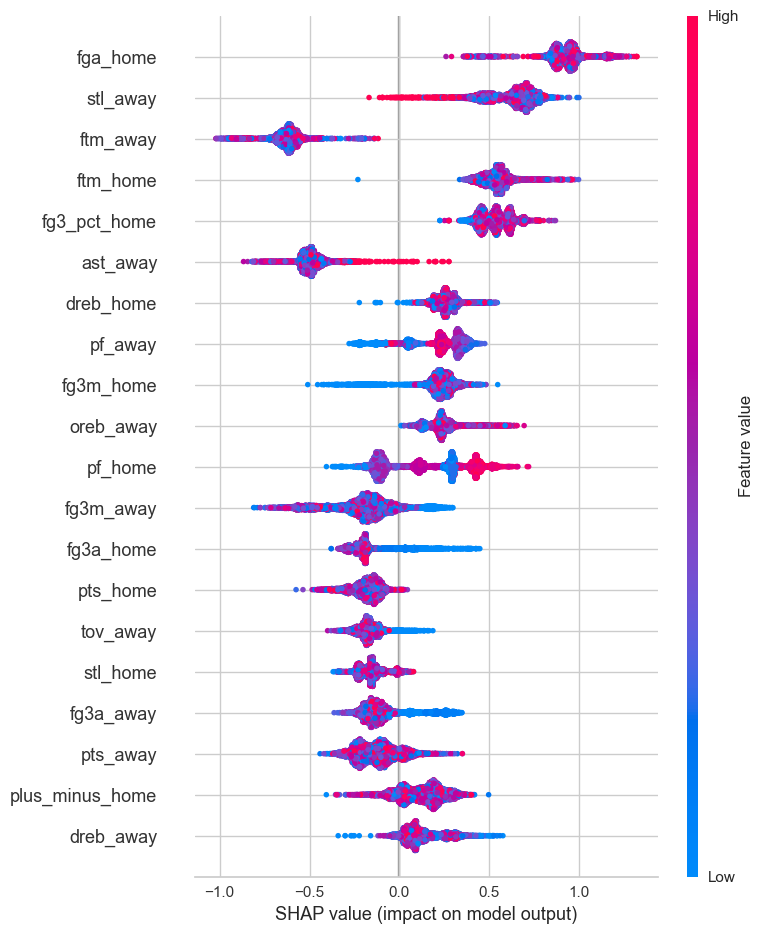

In [41]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


In [42]:
# # Identify categorical columns
# categorical_cols = ['season_type']

# # Convert categorical columns to numerical format
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col])
#     label_encoders[col] = le

# # Verify data types after conversion
# print("Data types in X after label encoding:\n", X.dtypes)


In [43]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define categorical and numerical columns
# numerical_cols = X.columns.difference(categorical_cols)

# # Preprocessing for numerical data
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# # Define the model
# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Create and evaluate the pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
# #
# # Perform cross-validation to check for data leakage
# cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# # Print cross-validation scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean Cross-Validation Score:", cv_scores.mean())

In [44]:
LAL_cleaned_data.columns

Index(['wl_home', 'min', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home',
       'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
       'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home',
       'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'oreb_diff_home',
       'oreb_diff_away', 'PREDICTION_OF_NEXT_GAME'],
      dtype='object')

In [45]:
# Split and train dataset
train_data, test_data = train_test_split(LAL_cleaned_data, test_size=0.2, random_state=42)

# Calculate the correlation matrix
correlation_matrix = train_data.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
train_data_reduced = train_data.drop(columns=to_drop)

# Drop low variance features
selector = VarianceThreshold(threshold=0.01)
train_data_reduced = pd.DataFrame(selector.fit_transform(train_data_reduced), columns=train_data_reduced.columns[selector.get_support(indices=True)])


# PyCaret

In [46]:
# Split and train dataset
train_data, test_data = train_test_split(LAL_cleaned_data, test_size=0.2, random_state=42)

# Calculate the correlation matrix
correlation_matrix = train_data.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
train_data_reduced = train_data.drop(columns=to_drop)

# Drop low variance features
selector = VarianceThreshold(threshold=0.01)
train_data_reduced = pd.DataFrame(selector.fit_transform(train_data_reduced), columns=train_data_reduced.columns[selector.get_support(indices=True)])

# Output the features to drop and the reduced DataFrame
print("Features to drop due to high correlation:", to_drop)
print("Reduced training data shape:", train_data_reduced.shape)

# Continue with the PyCaret setup and model training using train_data_reduced
exp_clf = setup(data=train_data_reduced, target='PREDICTION_OF_NEXT_GAME', session_id=42, normalize=True)

# Compare different models
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

# Finalize the model (train on the entire training dataset)
final_model = finalize_model(tuned_model)

# Ensure the test data has the same columns as the training data
missing_cols = set(train_data_reduced.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data_encoded = test_data[train_data_reduced.columns]

# Evaluate the model on the test set
test_evaluation = predict_model(final_model, data=test_data_encoded.drop(columns=['PREDICTION_OF_NEXT_GAME']))

# Print the performance metrics
print("Test Set Evaluation:")
print(test_evaluation)

Features to drop due to high correlation: ['fta_home', 'fta_away', 'plus_minus_away']
Reduced training data shape: (1412, 38)


,Description,Value
0,Session id,42
1,Target,PREDICTION_OF_NEXT_GAME
2,Target type,Binary
3,Original data shape,"(1412, 38)"
4,Transformed data shape,"(1412, 38)"
5,Transformed train set shape,"(988, 38)"
6,Transformed test set shape,"(424, 38)"
7,Numeric features,37
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6771,0.6455,0.8893,0.7044,0.7860,0.1623,0.1827,0.0440
lr,Logistic Regression,0.6751,0.6410,0.8832,0.7048,0.7836,0.1618,0.1812,0.1360
ridge,Ridge Classifier,0.6721,0.6424,0.8862,0.7011,0.7826,0.1494,0.1700,0.0060
lda,Linear Discriminant Analysis,0.6700,0.6413,0.8741,0.7035,0.7792,0.1539,0.1709,0.0080
dummy,Dummy Classifier,0.6670,0.5000,1.0000,0.6670,0.8002,0.0000,0.0000,0.2950
rf,Random Forest Classifier,0.6650,0.6414,0.8726,0.7000,0.7764,0.1381,0.1533,0.0440
xgboost,Extreme Gradient Boosting,0.6549,0.6271,0.8135,0.7111,0.7582,0.1630,0.1697,0.0260
gbc,Gradient Boosting Classifier,0.6529,0.6136,0.8468,0.6977,0.7646,0.1245,0.1342,0.1030
nb,Naive Bayes,0.6519,0.6594,0.7163,0.7525,0.7332,0.2320,0.2338,0.0060
knn,K Neighbors Classifier,0.6458,0.6041,0.8013,0.7075,0.7507,0.1442,0.1485,0.0120


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7374,0.6474,1.0000,0.7174,0.8354,0.2642,0.3901
1,0.7071,0.5523,0.9848,0.6989,0.8176,0.1714,0.2694
2,0.6869,0.6396,0.9697,0.6882,0.8050,0.1143,0.1796
3,0.6768,0.6887,0.9848,0.6771,0.8025,0.0588,0.1250
4,0.7071,0.6690,0.9697,0.7033,0.8153,0.1869,0.2621
5,0.6970,0.7328,0.9697,0.6957,0.8101,0.1509,0.2229
6,0.6566,0.6419,0.9545,0.6702,0.7875,0.0192,0.0326
7,0.6364,0.6047,0.9091,0.6667,0.7692,0.0000,0.0000
8,0.6939,0.7114,0.9846,0.6882,0.8101,0.1338,0.2273


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Test Set Evaluation:
       wl_home  min  fgm_home  fga_home  fg3m_home  fg3a_home  fg3_pct_home  \
59812        0  240      37.0      89.0        7.0       27.0         0.259   
23294        1  240      38.0      81.0        0.0        6.0         0.000   
60707        0  240      41.0      94.0       10.0       30.0         0.333   
39983        1  240      42.0      80.0        6.0       10.0         0.600   
50762        1  265      35.0      85.0        9.0       28.0         0.321   
...        ...  ...       ...       ...        ...        ...           ...   
33900        1  240      43.0      88.0        6.0       19.0         0.316   
36144        1  240      48.0      86.0        7.0       15.0         0.467   
63882        1  240      44.0      89.0       18.0       41.0         0.439   
33466        1  240      43.0      78.0        8.0       17.0         0.471   
36625        0  240      33.0      75.0        3.0       16.0         0.188   

       ftm_home  ft_pct_home  

# Extra Trees Classifier model chosen

In [47]:
# Define the parameter grid for Extra Trees Classifier
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [False, True]
}

# Initialize Extra Trees Classifier
etc = ExtraTreesClassifier(random_state=42)

# Set up GridSearchCV with fewer parallel jobs
grid_search = GridSearchCV(estimator=etc, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=2, verbose=2)

# Ensure 'is_home' is included in train_data_reduced and test_data
train_data_reduced['is_home'] = train_data_reduced.apply(lambda row: 1 if row.filter(like='_home').any() else 0, axis=1)
test_data['is_home'] = test_data.apply(lambda row: 1 if row.filter(like='_home').any() else 0, axis=1)

# Fit GridSearchCV
grid_search.fit(train_data_reduced.drop(columns=['PREDICTION_OF_NEXT_GAME']), train_data['PREDICTION_OF_NEXT_GAME'])

# View best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Get the best estimator
best_model = grid_search.best_estimator_

# Ensure the test data has the same columns as the training data
missing_cols = set(train_data_reduced.drop(columns=['PREDICTION_OF_NEXT_GAME']).columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data_encoded = test_data[train_data_reduced.drop(columns=['PREDICTION_OF_NEXT_GAME']).columns]

# Evaluate the model on the test set
test_evaluation = best_model.predict(test_data_encoded)
test_evaluation_df = pd.DataFrame(test_evaluation, columns=['prediction_label'])
test_evaluation_df['prediction_score'] = best_model.predict_proba(test_data_encoded)[:, 1]

# Print the performance metrics
print("Test Set Evaluation:")
print(classification_report(test_data['PREDICTION_OF_NEXT_GAME'], test_evaluation))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, m

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, m

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.56      0.18      0.27       114
         1.0       0.70      0.93      0.80       240

    accuracy                           0.69       354
   macro avg       0.63      0.55      0.53       354
weighted avg       0.66      0.69      0.63       354



In [48]:
# Apply SMOTE to the training data, to balance dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(train_data_reduced.drop(columns=['PREDICTION_OF_NEXT_GAME']), train_data['PREDICTION_OF_NEXT_GAME'])

# Split the resampled data into training and validation sets
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Initialize Extra Trees Classifier with balanced class weights
etc = ExtraTreesClassifier(random_state=42, class_weight='balanced')

# Fit the classifier to the resampled training data
etc.fit(X_train_smote, y_train_smote)

# Evaluate the model on the validation set
y_val_pred = etc.predict(X_val_smote)
print(classification_report(y_val_smote, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83       189
         1.0       0.81      0.86      0.83       188

    accuracy                           0.83       377
   macro avg       0.83      0.83      0.83       377
weighted avg       0.83      0.83      0.83       377



In [49]:
# Select the best features using SelectKBest, help the model capture more paterns and improve performance
selector = SelectKBest(f_classif, k=20)  # Select top 20 features

# Pipeline for feature selection and model training
pipeline = Pipeline([
    ('feature_selection', selector),
    ('classification', ExtraTreesClassifier(random_state=42, class_weight='balanced'))
])

# Fit the pipeline to the resampled training data
pipeline.fit(X_train_smote, y_train_smote)

# Evaluate the model on the validation set
y_val_pred = pipeline.predict(X_val_smote)
print(classification_report(y_val_smote, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       189
         1.0       0.82      0.81      0.82       188

    accuracy                           0.82       377
   macro avg       0.82      0.82      0.82       377
weighted avg       0.82      0.82      0.82       377



In [50]:
# Define base models, can improve the robustness and accuracy of the model
base_models = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('etc', ExtraTreesClassifier(random_state=42, class_weight='balanced'))
]

# Define meta-model
meta_model = LogisticRegression(random_state=42)

# Define stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier to the resampled training data
stacking_clf.fit(X_train_smote, y_train_smote)

# Evaluate the model on the validation set
y_val_pred = stacking_clf.predict(X_val_smote)
print(classification_report(y_val_smote, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83       189
         1.0       0.80      0.90      0.85       188

    accuracy                           0.84       377
   macro avg       0.85      0.84      0.84       377
weighted avg       0.85      0.84      0.84       377



# 5. New input

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1766 entries, 14166 to 65684
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   wl_home          1766 non-null   int64  
 1   min              1766 non-null   int64  
 2   fgm_home         1766 non-null   float64
 3   fga_home         1766 non-null   float64
 4   fg_pct_home      1766 non-null   float64
 5   fg3m_home        1766 non-null   float64
 6   fg3a_home        1766 non-null   float64
 7   fg3_pct_home     1766 non-null   float64
 8   ftm_home         1766 non-null   float64
 9   fta_home         1766 non-null   float64
 10  ft_pct_home      1766 non-null   float64
 11  oreb_home        1766 non-null   float64
 12  dreb_home        1766 non-null   float64
 13  reb_home         1766 non-null   float64
 14  ast_home         1766 non-null   float64
 15  stl_home         1766 non-null   float64
 16  blk_home         1766 non-null   float64
 17  tov_home      

# Export Model


In [52]:
import pickle

In [53]:
data = LAL_cleaned_data.copy()

# Define features and target variable
features = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 'fga_home', 'fga_away',
    'fg_pct_home', 'fg_pct_away', 'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away',
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 'ast_home', 'ast_away',
    'oreb_home', 'oreb_away', 'reb_home', 'reb_away', 'tov_home', 'tov_away',
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 'stl_home', 'stl_away',
    'dreb_home', 'dreb_away', 'wl_home', 'min', 'fg3a_home', 'fg3_pct_home',
    'plus_minus_home', 'fg3a_away', 'fg3_pct_away', 'plus_minus_away',
    'oreb_diff_home', 'oreb_diff_away'
]
target = 'PREDICTION_OF_NEXT_GAME'

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(data[features]), columns=features)
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.27      0.36       114
         1.0       0.72      0.89      0.79       240

    accuracy                           0.69       354
   macro avg       0.63      0.58      0.58       354
weighted avg       0.66      0.69      0.65       354

Model and imputer saved successfully!


In [54]:
# Save the model and imputer
data_to_save = {"model": model, "imputer": imputer}
with open('saved_model_v2.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Model and imputer saved successfully!")

Model and imputer saved successfully!


In [55]:
# Load the model and imputer
with open('saved_model_v2.pkl', 'rb') as file:
    data_loaded = pickle.load(file)

model_loaded = data_loaded["model"]
imputer_loaded = data_loaded["imputer"]

print("Model and imputer loaded successfully!")

Model and imputer loaded successfully!


In [56]:
def predict_outcome(team_data):
    # Ensure the input data has all necessary features
    for feature in features:
        if feature not in team_data.columns:
            team_data[feature] = 0
    team_data = team_data[features]
    
    # Impute missing values in the input data
    team_data_imputed = imputer_loaded.transform(team_data)
    
    # Make prediction
    prediction = model_loaded.predict(team_data_imputed)
    return 'Win' if prediction[0] == 1 else 'Lose'

# Example input for LAL playing at home
team_data_home = pd.DataFrame({
    'pts_home': [100], 'pts_away': [98], 'fgm_home': [40], 'fgm_away': [38],
    'fga_home': [85], 'fga_away': [83], 'fg_pct_home': [0.47], 'fg_pct_away': [0.46],
    'fg3m_home': [12], 'fg3m_away': [10], 'ftm_home': [8], 'ftm_away': [12],
    'fta_home': [10], 'fta_away': [15], 'ft_pct_home': [0.8], 'ft_pct_away': [0.8],
    'ast_home': [25], 'ast_away': [22], 'oreb_home': [10], 'oreb_away': [9],
    'reb_home': [50], 'reb_away': [48], 'tov_home': [15], 'tov_away': [14],
    'pf_home': [20], 'pf_away': [22], 'blk_home': [5], 'blk_away': [4],
    'stl_home': [7], 'stl_away': [6], 'dreb_home': [40], 'dreb_away': [39]
})

# Example input for LAL playing away
team_data_away = pd.DataFrame({
    'pts_home': [98], 'pts_away': [100], 'fgm_home': [38], 'fgm_away': [40],
    'fga_home': [83], 'fga_away': [85], 'fg_pct_home': [0.46], 'fg_pct_away': [0.47],
    'fg3m_home': [10], 'fg3m_away': [12], 'ftm_home': [12], 'ftm_away': [8],
    'fta_home': [15], 'fta_away': [10], 'ft_pct_home': [0.8], 'ft_pct_away': [0.8],
    'ast_home': [22], 'ast_away': [25], 'oreb_home': [9], 'oreb_away': [10],
    'reb_home': [48], 'reb_away': [50], 'tov_home': [14], 'tov_away': [15],
    'pf_home': [22], 'pf_away': [20], 'blk_home': [4], 'blk_away': [5],
    'stl_home': [6], 'stl_away': [7], 'dreb_home': [39], 'dreb_away': [40],
    'fg3a_home': [0], 'fg3a_away': [0], 'fg3_pct_home': [0], 'fg3_pct_away': [0],
    'min': [0], 'plus_minus_home': [0], 'plus_minus_away': [0]
})

# Predict and display the outcome for both scenarios
outcome_home = predict_outcome(team_data_home)
print(f'The predicted outcome for LAL at home is: {outcome_home}')

outcome_away = predict_outcome(team_data_away)
print(f'The predicted outcome for LAL away is: {outcome_away}')

The predicted outcome for LAL at home is: Lose
The predicted outcome for LAL away is: Lose


In [57]:
# Ensure the feature names are aligned with those used in training
features = [
    'pts_home', 'pts_away', 'fgm_home', 'fgm_away', 'fga_home', 'fga_away',
    'fg_pct_home', 'fg_pct_away', 'fg3m_home', 'fg3m_away', 'ftm_home', 'ftm_away',
    'fta_home', 'fta_away', 'ft_pct_home', 'ft_pct_away', 'ast_home', 'ast_away',
    'oreb_home', 'oreb_away', 'reb_home', 'reb_away', 'tov_home', 'tov_away',
    'pf_home', 'pf_away', 'blk_home', 'blk_away', 'stl_home', 'stl_away',
    'dreb_home', 'dreb_away', 'wl_home', 'min', 'fg3a_home', 'fg3_pct_home',
    'plus_minus_home', 'fg3a_away', 'fg3_pct_away', 'plus_minus_away',
    'oreb_diff_home', 'oreb_diff_away'
]

# Define the prediction function
def predict_outcome(team_data):
    # Ensure the input data has all necessary features
    for feature in features:
        if feature not in team_data.columns:
            team_data[feature] = 0
    team_data = team_data[features]
    
    # Impute missing values in the input data
    team_data_imputed = imputer_loaded.transform(team_data)
    
    # Make prediction
    prediction = model_loaded.predict(team_data_imputed)
    return 'Win' if prediction[0] == 1 else 'Lose'

# Example input for LAL playing away (updated with different numbers)
team_data_away = pd.DataFrame({
    'pts_home': [102], 'pts_away': [105], 'fgm_home': [37], 'fgm_away': [42],
    'fga_home': [80], 'fga_away': [90], 'fg_pct_home': [0.46], 'fg_pct_away': [0.47],
    'fg3m_home': [11], 'fg3m_away': [14], 'ftm_home': [10], 'ftm_away': [15],
    'fta_home': [13], 'fta_away': [20], 'ft_pct_home': [0.77], 'ft_pct_away': [0.75],
    'ast_home': [24], 'ast_away': [28], 'oreb_home': [8], 'oreb_away': [11],
    'reb_home': [45], 'reb_away': [53], 'tov_home': [13], 'tov_away': [16],
    'pf_home': [19], 'pf_away': [21], 'blk_home': [3], 'blk_away': [6],
    'stl_home': [5], 'stl_away': [8], 'dreb_home': [37], 'dreb_away': [42],
    'is_home': [0]
})

# Run prediction from loaded model
outcome_away = predict_outcome(team_data_away)
print(f'The predicted outcome for LAL away is: {outcome_away}')

The predicted outcome for LAL away is: Lose


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth